# HYPOTHESIS 1: Infants are expected to demonstrate varying exploration patterns in response to changes in difficulty

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene, kruskal, sem, f_oneway, linregress, spearmanr
from sklearn.utils import resample
import random 
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

In [2]:
#Read the dataset and drop NaN values

data = 'data_thesis.csv'

data = pd.read_csv(data)

data.dropna(inplace=True)
data.drop(data[data['period_in_trial'] == 'feedback'].index, inplace=True)
data.drop(data[data['sideMatch'] == 'timedout'].index, inplace=True)
data.drop(data[data['accuracy'] == 0.5].index, inplace=True)

data['durLookBottom'] = data['LookTotDurInL'] + data['LookTotDurInR'] #New variable: durLookBottom
data['FixNbInBottom'] = data['FixNbInL'] + data['FixNbInR'] #New variable: FixNbInBottom
data['durfixBottom'] = data['FixTotDurInL'] + data['FixTotDurInR'] #New variable: durFixBottom

data

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
3     curE002a        9       Easy       1.0     exploration             3   
4     curE002a        9       Easy       1.0        decision             3   
6     curE002a       10       Easy       1.0     exploration             3   
...        ...      ...        ...       ...             ...           ...   
5862  curE125a       27       Easy       0.0        decision             2   
5871  curE125a       33       Easy       1.0     exploration             2   
5872  curE125a       33       Easy       1.0        decision             2   
5877  curE125a       39       Easy       0.0     exploration             2   
5878  curE125a       39       Easy       0.0        decision             2   

      durPeriodTotal  FixNb  FixNbInL  FixNbInR  ...         objL  \
0              11270     20        13         5  ...  V-1-G-1.png   
1                924      2         1         0  ...  V-1-G-1.png   
3               2498      6         3         2  ...  F-1-A-3.png   
4               2182      4         1         0  ...  F-1-A-3.png   
6               9912     11         3         5  ...  F-4-E-1.png   
...              ...    ...       ...       ...  ...          ...   
5862           10032     24         0         0  ...  O-3-H-1.png   
5871           18792     34        22         9  ...  F-3-G-4.png   
5872           10040     11         0         0  ...  F-3-G-4.png   
5877            5248     10         4         3  ...  O-3-H-1.png   
5878           10038      9         0         0  ...  O-3-H-1.png   

             objR         objT  sideChosen  sideMatch  timePeriodStarts  \
0     F-4-E-1.png  F-4-E-1.png        left      right            1962.0   
1     F-4-E-1.png  F-4-E-1.png        left      right           13232.0   
3     V-2-H-2.png  F-1-A-3.png        left       left            2024.0   
4     V-2-H-2.png  F-1-A-3.png        left       left            4522.0   
6     V-1-G-1.png  V-1-G-1.png       right      right            2046.0   
...           ...          ...         ...        ...               ...   
5862  F-2-G-4.png  F-2-G-4.png        left      right            7242.0   
5871  A-1-I-4.png  F-3-G-4.png        left       left            9560.0   
5872  A-1-I-4.png  F-3-G-4.png        left       left           15574.0   
5877  F-2-G-4.png  O-3-H-1.png       right       left            1276.0   
5878  F-2-G-4.png  O-3-H-1.png       right       left            3604.0   

      timePeriodEnds  durLookBottom  FixNbInBottom  durfixBottom  
0            13230.0           5480             18          4952  
1            14154.0            536              1           536  
3             4520.0           1670              5          1468  
4             6702.0            530              1           470  
6            11956.0           2658              8          2546  
...              ...            ...            ...           ...  
5862         12338.0              0              0             0  
5871         15572.0          12008             31         11146  
5872         19054.0              0              0             0  
5877          3602.0           3042              7          2826  
5878         12536.0              0              0             0  

[3025 rows x 35 columns]

In [3]:
# Filter out participants that didn't go above easy difficulty level

grouped = data.groupby('session')

filtered_sessions = []
for session, data in grouped:
    if 'Easy' not in data['difficulty'].values or len(data['difficulty'].unique()) > 1:
        filtered_sessions.append(data)

data = pd.concat(filtered_sessions)
data

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
3     curE002a        9       Easy       1.0     exploration             3   
4     curE002a        9       Easy       1.0        decision             3   
6     curE002a       10       Easy       1.0     exploration             3   
...        ...      ...        ...       ...             ...           ...   
5787  curE122a       43       Hard       0.0     exploration             1   
5788  curE122a       45     Medium       1.0     exploration             3   
5790  curE122a       46     Medium       0.0        decision             3   
5791  curE122a       48     Medium       0.0     exploration             3   
5792  curE122a       48     Medium       0.0        decision             3   

      durPeriodTotal  FixNb  FixNbInL  FixNbInR  ...         objL  \
0              11270     20        13         5  ...  V-1-G-1.png   
1                924      2         1         0  ...  V-1-G-1.png   
3               2498      6         3         2  ...  F-1-A-3.png   
4               2182      4         1         0  ...  F-1-A-3.png   
6               9912     11         3         5  ...  F-4-E-1.png   
...              ...    ...       ...       ...  ...          ...   
5787           20008     20        20         0  ...  O-2-J-1.png   
5788            3530      2         0         1  ...  O-3-B-4.png   
5790            1716      5         2         0  ...  V-4-G-3.png   
5791            2332      2         1         0  ...  V-2-B-3.png   
5792             968      3         2         0  ...  V-2-B-3.png   

             objR         objT  sideChosen  sideMatch  timePeriodStarts  \
0     F-4-E-1.png  F-4-E-1.png        left      right            1962.0   
1     F-4-E-1.png  F-4-E-1.png        left      right           13232.0   
3     V-2-H-2.png  F-1-A-3.png        left       left            2024.0   
4     V-2-H-2.png  F-1-A-3.png        left       left            4522.0   
6     V-1-G-1.png  V-1-G-1.png       right      right            2046.0   
...           ...          ...         ...        ...               ...   
5787  O-2-G-4.png  O-2-G-4.png        left      right            4456.0   
5788  O-1-D-2.png  O-3-B-4.png        left       left            1650.0   
5790  V-1-A-4.png  V-1-A-4.png        left      right           20952.0   
5791  V-3-H-3.png  V-3-H-3.png        left      right            1488.0   
5792  V-3-H-3.png  V-3-H-3.png        left      right           17712.0   

      timePeriodEnds  durLookBottom  FixNbInBottom  durfixBottom  
0            13230.0           5480             18          4952  
1            14154.0            536              1           536  
3             4520.0           1670              5          1468  
4             6702.0            530              1           470  
6            11956.0           2658              8          2546  
...              ...            ...            ...           ...  
5787          7984.0           5162             20          3806  
5788          3980.0            114              1           114  
5790         23084.0            464              2           434  
5791         17710.0            596              1           596  
5792         20258.0            468              2           468  

[2786 rows x 35 columns]

In [4]:
# Filter out participants that completed 10 or less trials

trial_counts_per_session = data.groupby('session')['trialno'].nunique()

trial_counts_df = trial_counts_per_session.reset_index(name='unique_trial_count')

data = data[data['session'].isin(trial_counts_df[trial_counts_df['unique_trial_count'] > 10]['session'])]

data

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
3     curE002a        9       Easy       1.0     exploration             3   
4     curE002a        9       Easy       1.0        decision             3   
6     curE002a       10       Easy       1.0     exploration             3   
...        ...      ...        ...       ...             ...           ...   
5787  curE122a       43       Hard       0.0     exploration             1   
5788  curE122a       45     Medium       1.0     exploration             3   
5790  curE122a       46     Medium       0.0        decision             3   
5791  curE122a       48     Medium       0.0     exploration             3   
5792  curE122a       48     Medium       0.0        decision             3   

      durPeriodTotal  FixNb  FixNbInL  FixNbInR  ...         objL  \
0              11270     20        13         5  ...  V-1-G-1.png   
1                924      2         1         0  ...  V-1-G-1.png   
3               2498      6         3         2  ...  F-1-A-3.png   
4               2182      4         1         0  ...  F-1-A-3.png   
6               9912     11         3         5  ...  F-4-E-1.png   
...              ...    ...       ...       ...  ...          ...   
5787           20008     20        20         0  ...  O-2-J-1.png   
5788            3530      2         0         1  ...  O-3-B-4.png   
5790            1716      5         2         0  ...  V-4-G-3.png   
5791            2332      2         1         0  ...  V-2-B-3.png   
5792             968      3         2         0  ...  V-2-B-3.png   

             objR         objT  sideChosen  sideMatch  timePeriodStarts  \
0     F-4-E-1.png  F-4-E-1.png        left      right            1962.0   
1     F-4-E-1.png  F-4-E-1.png        left      right           13232.0   
3     V-2-H-2.png  F-1-A-3.png        left       left            2024.0   
4     V-2-H-2.png  F-1-A-3.png        left       left            4522.0   
6     V-1-G-1.png  V-1-G-1.png       right      right            2046.0   
...           ...          ...         ...        ...               ...   
5787  O-2-G-4.png  O-2-G-4.png        left      right            4456.0   
5788  O-1-D-2.png  O-3-B-4.png        left       left            1650.0   
5790  V-1-A-4.png  V-1-A-4.png        left      right           20952.0   
5791  V-3-H-3.png  V-3-H-3.png        left      right            1488.0   
5792  V-3-H-3.png  V-3-H-3.png        left      right           17712.0   

      timePeriodEnds  durLookBottom  FixNbInBottom  durfixBottom  
0            13230.0           5480             18          4952  
1            14154.0            536              1           536  
3             4520.0           1670              5          1468  
4             6702.0            530              1           470  
6            11956.0           2658              8          2546  
...              ...            ...            ...           ...  
5787          7984.0           5162             20          3806  
5788          3980.0            114              1           114  
5790         23084.0            464              2           434  
5791         17710.0            596              1           596  
5792         20258.0            468              2           468  

[2642 rows x 35 columns]

In [5]:
# Summary statistics
print(data.describe())

           trialno     accuracy  step_reached  durPeriodTotal        FixNb  \
count  2642.000000  2642.000000   2642.000000     2642.000000  2642.000000   
mean     26.377744     0.523467      2.863361     5094.348221     8.730129   
std      14.203303     0.499544      0.438438     4793.427111     7.691333   
min       7.000000     0.000000      1.000000      550.000000     0.000000   
25%      15.000000     0.000000      3.000000     1982.000000     4.000000   
50%      24.000000     1.000000      3.000000     3098.000000     6.000000   
75%      35.000000     1.000000      3.000000     6581.500000    11.000000   
max      87.000000     1.000000      3.000000    21074.000000    51.000000   

          FixNbInL     FixNbInR     FixNbInT   FixNbNoAOI  FixTotDurInL  ...  \
count  2642.000000  2642.000000  2642.000000  2642.000000   2642.000000  ...   
mean      3.116200     2.857305     2.540121     0.216503   1025.705526  ...   
std       4.924009     4.425375     2.776562     0.544902

In [6]:
# Divide the dataset into decision and exploration rows
decision_data = data[data['period_in_trial'] == 'decision']
exploration_data = data[data['period_in_trial'] == 'exploration']

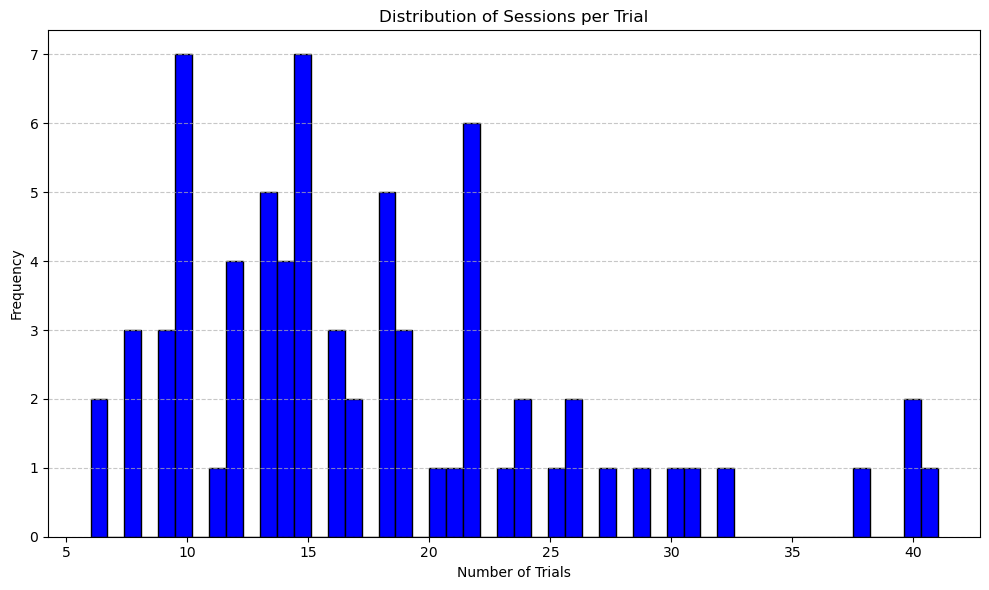

In [7]:
# Distribution of session per trial number
trials_per_session = decision_data.groupby('session')['trialno'].nunique()

# Plot the number of trials per session
plt.figure(figsize=(10, 6))
plt.hist(trials_per_session, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Sessions per Trial')
plt.xlabel('Number of Trials')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Difficulty counts:
difficulty
Easy      560
Medium    386
Hard      221
xHard     109
Name: count, dtype: int64


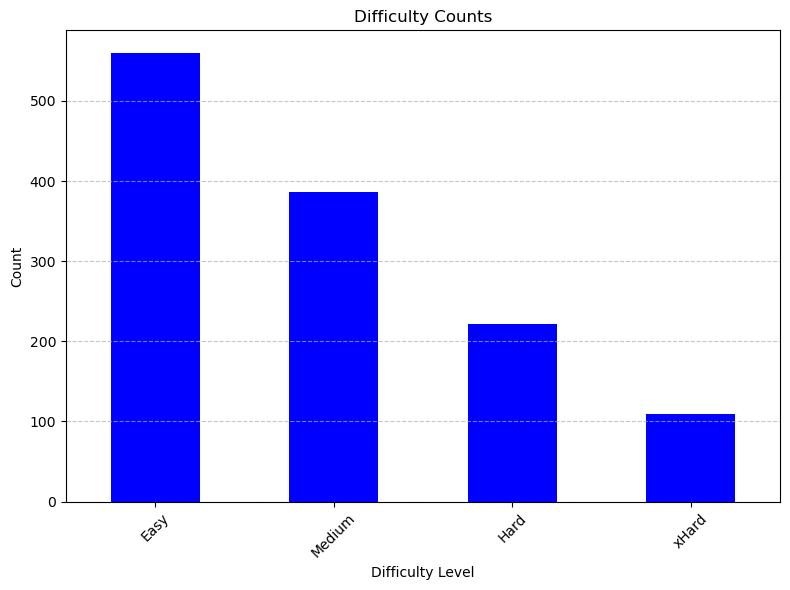

In [8]:
#Count of Difficulty Levels 

difficulty_counts = decision_data['difficulty'].value_counts()

print("Difficulty counts:")
print(difficulty_counts)

plt.figure(figsize=(8, 6))
difficulty_counts.plot(kind='bar', color='blue')
plt.title('Difficulty Counts')
plt.xlabel('Difficulty Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

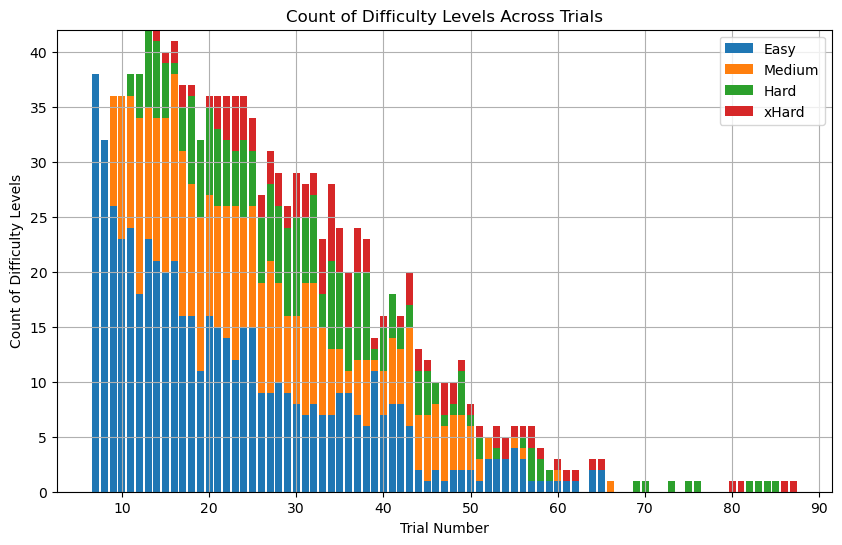

In [9]:
# Difficulty levels count across trials

difficulty_order = ['Easy', 'Medium', 'Hard', 'xHard']
difficulty_trial_counts = decision_data.groupby(['trialno', 'difficulty']).size().unstack(fill_value=0)
difficulty_trial_counts = difficulty_trial_counts[difficulty_order]

plt.figure(figsize=(10, 6))

bottom = None
for difficulty in difficulty_trial_counts.columns:
    plt.bar(difficulty_trial_counts.index, difficulty_trial_counts[difficulty], label=difficulty, bottom=bottom)
    if bottom is None:
        bottom = difficulty_trial_counts[difficulty].values
    else:
        bottom += difficulty_trial_counts[difficulty].values

plt.xlabel('Trial Number')
plt.ylabel('Count of Difficulty Levels')
plt.title('Count of Difficulty Levels Across Trials')
plt.legend()
plt.grid(True)
plt.show()

# Features + Difficulty Level Analysis

## Accuracy vs. Difficulty Level

Shapiro-Wilk test for Easy: p-value = 7.253260460957236e-33
Shapiro-Wilk test for Hard: p-value = 1.8966851574211576e-21
Shapiro-Wilk test for Medium: p-value = 7.336723732155045e-28
Shapiro-Wilk test for xHard: p-value = 4.0618550429627235e-15
Levene's test for homogeneity of variances: p-value = 0.8464691727553204
Kruskal-Wallis test:
H-statistic: 5.5596315130793625
p-value: 0.13511517857296107


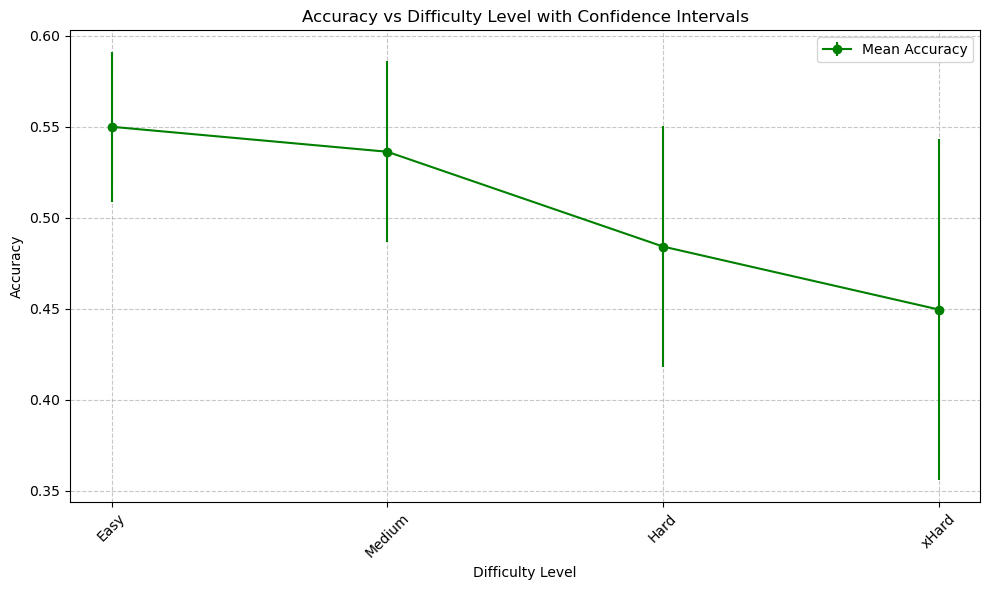

Accuracy means per difficulty level:
difficulty
Easy      0.550000
Medium    0.536269
Hard      0.484163
xHard     0.449541
Name: accuracy, dtype: float64
Accuracy medians per difficulty level:
difficulty
Easy      1.0
Medium    1.0
Hard      0.0
xHard     0.0
Name: accuracy, dtype: float64


In [7]:
#Accuracy means by difficulty level

difficulty_order = ['Easy', 'Medium', 'Hard', 'xHard']

mean_accuracy = decision_data.groupby('difficulty')['accuracy'].mean().loc[difficulty_order]
median_accuracy = decision_data.groupby('difficulty')['accuracy'].median().loc[difficulty_order]
std_accuracy = decision_data.groupby('difficulty')['accuracy'].std().loc[difficulty_order]
count_accuracy = decision_data.groupby('difficulty')['accuracy'].count().loc[difficulty_order]
conf_interval = 1.96 * std_accuracy / np.sqrt(count_accuracy)

# Shapiro-Wilk test for normality 
for group_name, group_data in decision_data.groupby('difficulty')['accuracy']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances 
stat, p = levene(*[group_data for group_name, group_data in decision_data.groupby('difficulty')['accuracy']])
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test 
H, p = kruskal(*[group_data for group_name, group_data in decision_data.groupby('difficulty')['accuracy']])
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

#Error bars with confidence intervals
plt.figure(figsize=(10, 6))

plt.errorbar(mean_accuracy.index, mean_accuracy, yerr=conf_interval, fmt='o', linestyle='-', color='green', label='Mean Accuracy')

plt.title('Accuracy vs Difficulty Level with Confidence Intervals')
plt.xlabel('Difficulty Level')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Accuracy means per difficulty level:")
print(mean_accuracy)

print("Accuracy medians per difficulty level:")
print(median_accuracy)

Shapiro-Wilk test for Easy: p-value = 7.253260460957236e-33
Shapiro-Wilk test for Hard: p-value = 1.8966851574211576e-21
Shapiro-Wilk test for Medium: p-value = 7.336723732155045e-28
Shapiro-Wilk test for xHard: p-value = 4.0618550429627235e-15
Levene's test for homogeneity of variances: p-value = 0.8464691727553204
Kruskal-Wallis test:
H-statistic: 5.5596315130793625
p-value: 0.13511517857296107


C:\Users\I587504\AppData\Local\Temp\ipykernel_153592\3144979797.py:35: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(overall_mean_accuracy.index, overall_mean_accuracy.values, yerr=overall_conf_interval_mean, fmt='o', color='green', label='Overall Mean Accuracy', marker='o')


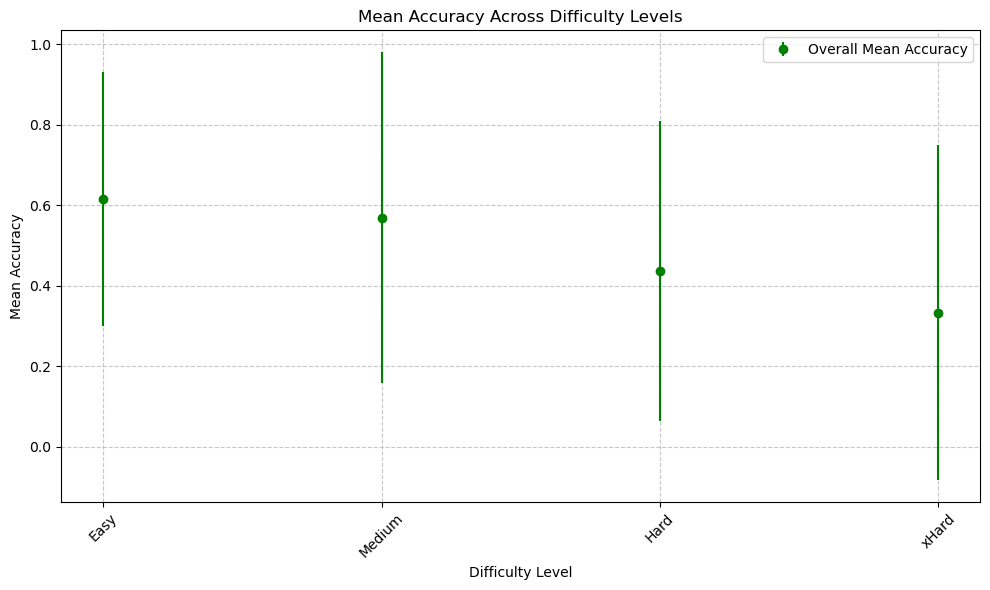

Overall Mean Accuracy per Difficulty Level Across Sessions:
difficulty
Easy      0.615208
Medium    0.569052
Hard      0.437196
xHard     0.333056
dtype: float64


In [23]:
# Means across sessions 

session_mean_accuracy = decision_data.groupby(['session', 'difficulty'])['accuracy'].mean().unstack()
session_median_accuracy = decision_data.groupby(['session', 'difficulty'])['accuracy'].median().unstack()

overall_mean_accuracy = session_mean_accuracy.mean()
overall_median_accuracy = session_median_accuracy.median()

overall_mean_accuracy = overall_mean_accuracy.reindex(difficulty_order)
overall_median_accuracy = overall_median_accuracy.reindex(difficulty_order)

session_std_accuracy = decision_data.groupby(['session', 'difficulty'])['accuracy'].std().unstack()
session_count_accuracy = decision_data.groupby(['session', 'difficulty'])['accuracy'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_accuracy.mean() / np.sqrt(session_count_accuracy.mean())

# Shapiro-Wilk test for normality
for group_name, group_data in decision_data.groupby('difficulty')['accuracy']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*[group_data for group_name, group_data in decision_data.groupby('difficulty')['accuracy']])
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*[group_data for group_name, group_data in decision_data.groupby('difficulty')['accuracy']])
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

overall_conf_interval_median = 1.96 * session_median_accuracy.std() / np.sqrt(session_median_accuracy.count())

# Mean accuracy across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_accuracy.index, overall_mean_accuracy.values, yerr=overall_conf_interval_mean, fmt='o', color='green', label='Overall Mean Accuracy', marker='o')
plt.title('Mean Accuracy Across Difficulty Levels')
plt.xlabel('Difficulty Level')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Overall Mean Accuracy per Difficulty Level Across Sessions:")
print(overall_mean_accuracy)

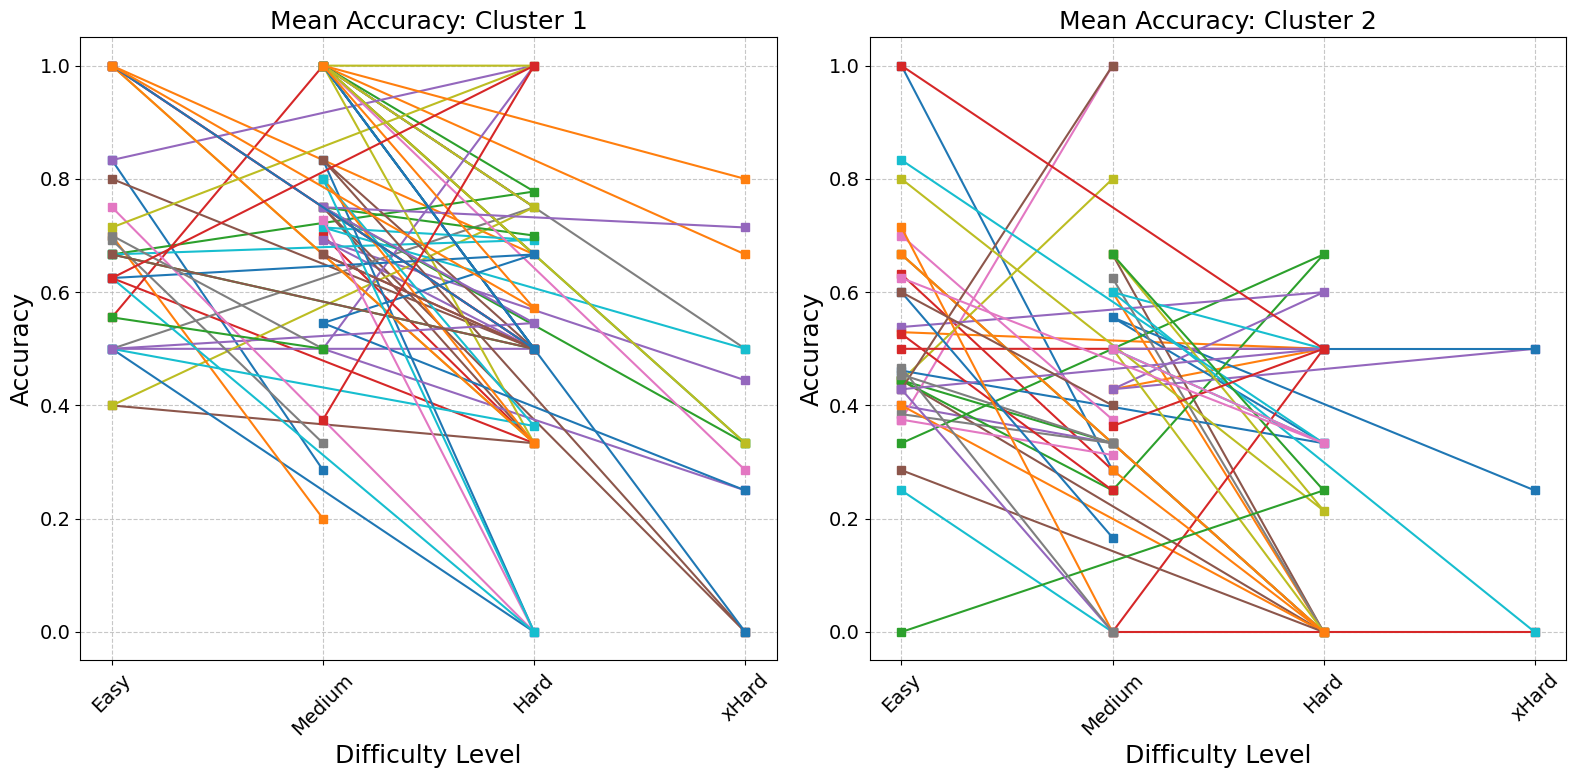

In [35]:
# Accuracy per session by difficulty level

session_mean_accuracy = decision_data.groupby(['session', 'difficulty'])['accuracy'].mean().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE040a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE076a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # Create two subplots side by side

# Sessions cluster 1
axs[0].set_title('Mean Accuracy: Cluster 1', fontsize=18)
for session in sessions_cluster_1:
    if session in session_mean_accuracy.index:
        available_difficulty_levels = session_mean_accuracy.loc[session].dropna().index.tolist()
        if available_difficulty_levels:
            mean_accuracy_session = session_mean_accuracy.loc[session][available_difficulty_levels]
            axs[0].plot(mean_accuracy_session.index, mean_accuracy_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

axs[0].set_xlabel('Difficulty Level', fontsize=18)
axs[0].set_ylabel('Accuracy', fontsize=18)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].tick_params(axis='x', rotation=45)
#axs[0].legend()

# Sessions cluster 2
axs[1].set_title('Mean Accuracy: Cluster 2', fontsize=18)
for session in sessions_cluster_2:
    if session in session_mean_accuracy.index:
        available_difficulty_levels = session_mean_accuracy.loc[session].dropna().index.tolist()
        if available_difficulty_levels:
            mean_accuracy_session = session_mean_accuracy.loc[session][available_difficulty_levels]
            axs[1].plot(mean_accuracy_session.index, mean_accuracy_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

axs[1].set_xlabel('Difficulty Level', fontsize=18)
axs[1].set_ylabel('Accuracy', fontsize=18)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='x', rotation=45) 
#axs[1].legend()

plt.tight_layout()
plt.show()

## Total trial duration vs. Difficulty Level

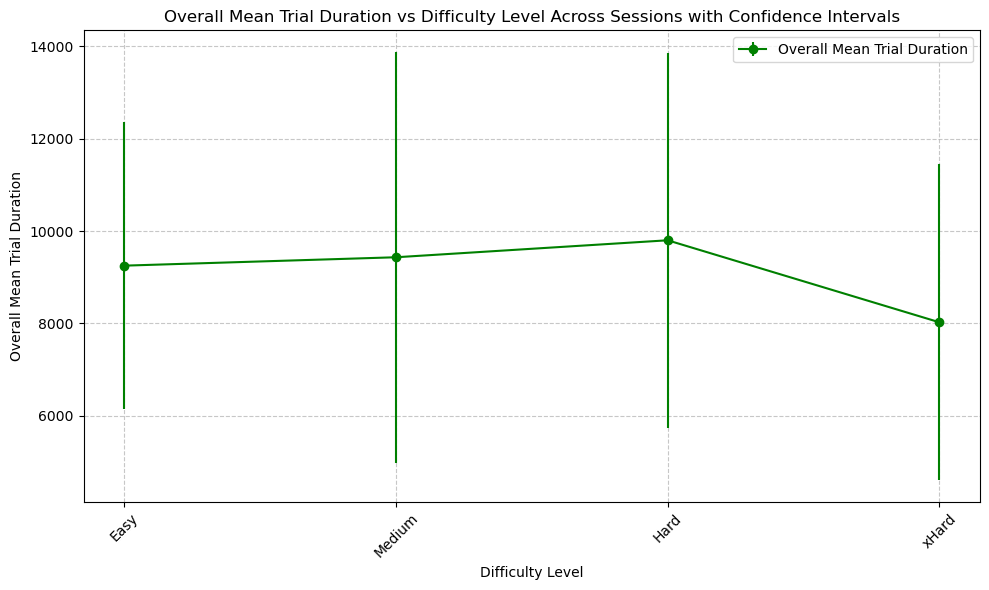

Overall Mean Trial Duration per Difficulty Level Across Sessions:
difficulty
Easy      9250.379387
Medium    9432.017389
Hard      9799.202301
xHard     8025.845734
dtype: float64


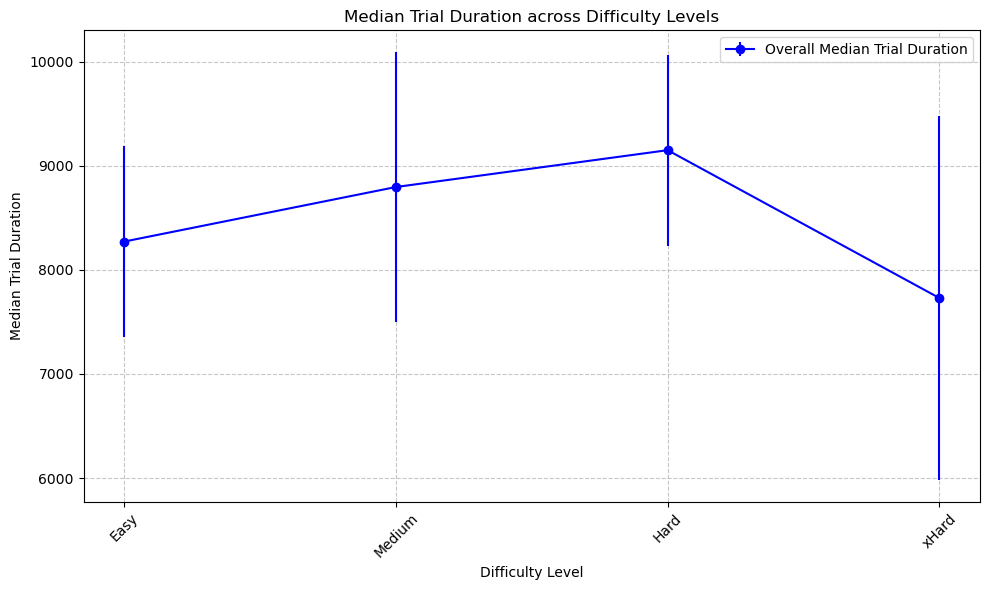


Overall Median Trial Duration per Difficulty Level Across Sessions:
difficulty
Easy      8272.200000
Medium    8796.112676
Hard      9149.808511
xHard     7730.150000
dtype: float64
Shapiro-Wilk test for Easy: p-value = 5.985069371333392e-38
Shapiro-Wilk test for Hard: p-value = 1.466950277247459e-23
Shapiro-Wilk test for Medium: p-value = 1.3405217298087222e-31
Shapiro-Wilk test for xHard: p-value = 4.637725961742047e-19
Levene's test for homogeneity of variances: p-value = 0.5580824344004918
Kruskal-Wallis test:
H-statistic: 5.175593457624233
p-value: 0.04738172169473455


In [14]:
# Means and medians across sessions (first session by session, then medians/ means of that)

total_trial_duration_per_trial = data.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

session_mean_durPeriodTotal = total_trial_duration_per_trial.groupby(['session', 'difficulty'])['durPeriodTotal'].mean().unstack()
session_median_durPeriodTotal = total_trial_duration_per_trial.groupby(['session', 'difficulty'])['durPeriodTotal'].median().unstack()

overall_mean_durPeriodTotal = session_mean_durPeriodTotal.mean()
overall_median_durPeriodTotal = session_median_durPeriodTotal.mean()

overall_mean_durPeriodTotal = overall_mean_durPeriodTotal.reindex(difficulty_order)
overall_median_durPeriodTotal = overall_median_durPeriodTotal.reindex(difficulty_order)

session_std_durPeriodTotal = total_trial_duration_per_trial.groupby(['session', 'difficulty'])['durPeriodTotal'].std().unstack()
session_count_durPeriodTotal = total_trial_duration_per_trial.groupby(['session', 'difficulty'])['durPeriodTotal'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_durPeriodTotal.mean() / np.sqrt(session_count_durPeriodTotal.mean())

overall_conf_interval_median = 1.96 * session_median_durPeriodTotal.std() / np.sqrt(session_median_durPeriodTotal.count())

# Mean trial duration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_durPeriodTotal.index, overall_mean_durPeriodTotal.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Trial Duration')
plt.title('Overall Mean Trial Duration vs Difficulty Level Across Sessions with Confidence Intervals')
plt.xlabel('Difficulty Level')
plt.ylabel('Overall Mean Trial Duration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Overall Mean Trial Duration per Difficulty Level Across Sessions:")
print(overall_mean_durPeriodTotal)

# Median trial duration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_durPeriodTotal.index, overall_median_durPeriodTotal.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Overall Median Trial Duration')
plt.title('Median Trial Duration across Difficulty Levels')
plt.xlabel('Difficulty Level')
plt.ylabel('Median Trial Duration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nOverall Median Trial Duration per Difficulty Level Across Sessions:")
print(overall_median_durPeriodTotal)

durperiod_by_difficulty = [data[data['difficulty'] == level]['durPeriodTotal'] for level in data['difficulty'].unique()]

# Shapiro-Wilk test for normality 
for group_name, group_data in data.groupby('difficulty')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances 
stat, p = levene(*[group_data for group_name, group_data in data.groupby('difficulty')['durPeriodTotal']])
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test 
H, p = kruskal(*[group_data for group_name, group_data in data.groupby('difficulty')['durPeriodTotal']])
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

In [15]:
pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


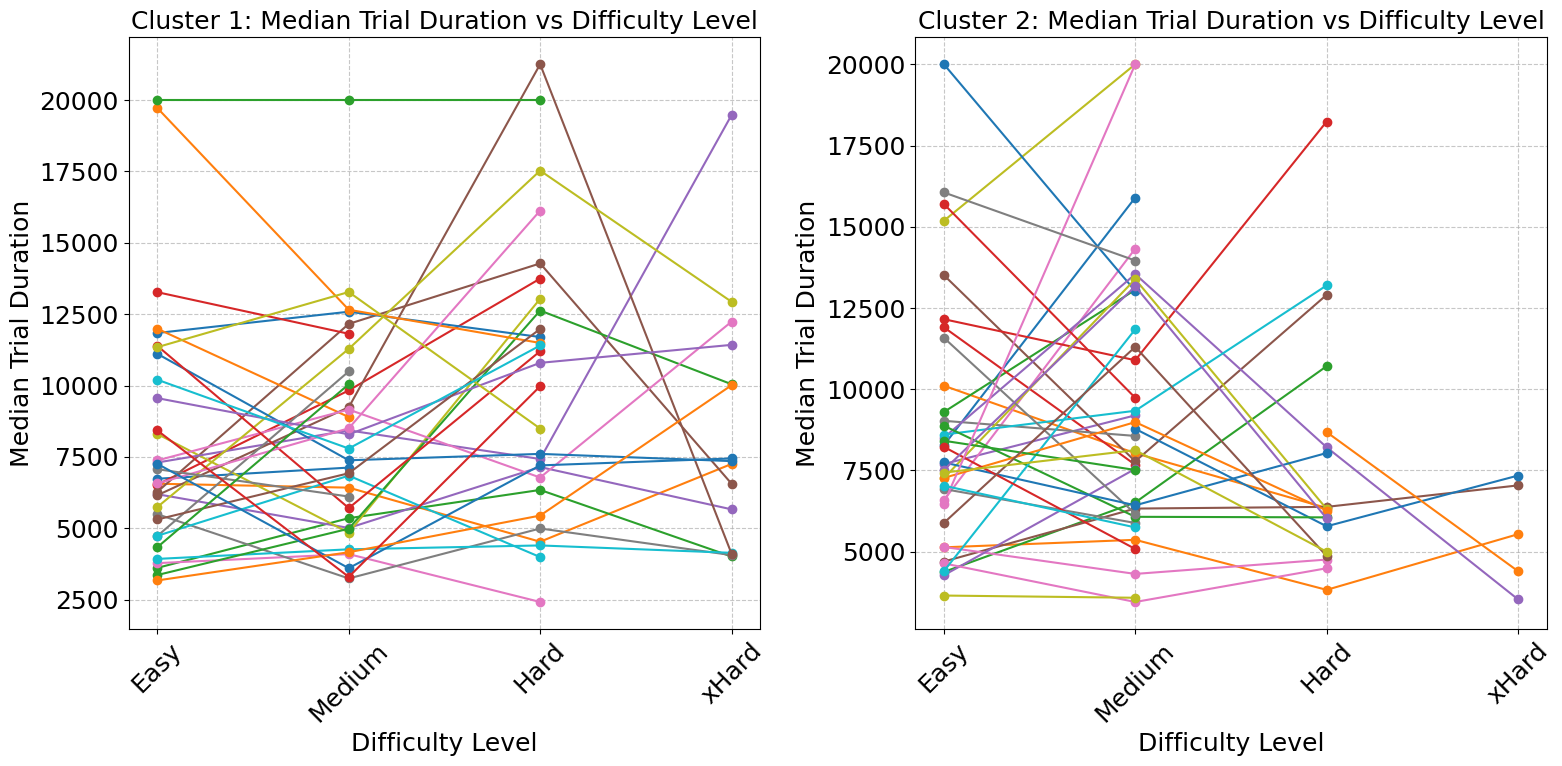

In [53]:
# Median trial duration per session by difficulty level

difficulty_order = ['Easy', 'Medium', 'Hard', 'xHard']

total_trial_duration_per_trial = data.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE040a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE076a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

# Increase font size globally
plt.rcParams.update({'font.size': 18})

# Session cluster 1
axs[0].set_title('Cluster 1: Median Trial Duration vs Difficulty Level', fontsize=18)
for session_id in sessions_cluster_1:
    session_data = total_trial_duration_per_trial[total_trial_duration_per_trial['session'] == session_id]
    median_trial_duration_per_session = session_data.groupby('difficulty')['durPeriodTotal'].median().reindex(difficulty_order) 
    axs[0].plot(median_trial_duration_per_session.index,  median_trial_duration_per_session, marker='o', linestyle='-', label=f'Session {session_id}')

axs[0].set_xlabel('Difficulty Level', fontsize=18)
axs[0].set_ylabel('Median Trial Duration', fontsize=18)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].tick_params(axis='x', rotation=45, labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)

# Session cluster 2
axs[1].set_title('Cluster 2: Median Trial Duration vs Difficulty Level', fontsize=18)
for session_id in sessions_cluster_2:
    session_data = total_trial_duration_per_trial[total_trial_duration_per_trial['session'] == session_id]
    median_trial_duration_per_session = session_data.groupby('difficulty')['durPeriodTotal'].median().reindex(difficulty_order) 
    axs[1].plot(median_trial_duration_per_session.index,  median_trial_duration_per_session, marker='o', linestyle='-', label=f'Session {session_id}')

axs[1].set_xlabel('Difficulty Level', fontsize=18)
axs[1].set_ylabel('Median Trial Duration', fontsize=18)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='x', rotation=45, labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.show()


## Duration of exploration and decision periods vs. Difficulty Level

In [8]:
durexploration_by_difficulty = [exploration_data[exploration_data['difficulty'] == level]['durPeriodTotal'] for level in exploration_data['difficulty'].unique()]
durdecision_by_difficulty = [decision_data[decision_data['difficulty'] == level]['durPeriodTotal'] for level in decision_data['difficulty'].unique()]

#For exploration period duration
# Shapiro-Wilk test for normality
for group_name, group_data in exploration_data.groupby('difficulty')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*durexploration_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*durexploration_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

#For decision period duration
# Shapiro-Wilk test for normality
for group_name, group_data in decision_data.groupby('difficulty')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*durdecision_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*durdecision_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

Shapiro-Wilk test for Easy: p-value = 3.235221332937525e-28
Shapiro-Wilk test for Hard: p-value = 4.250275044890156e-15
Shapiro-Wilk test for Medium: p-value = 1.8318391435106937e-22
Shapiro-Wilk test for xHard: p-value = 2.6581855648403466e-13
Levene's test for homogeneity of variances: p-value = 0.54064105330517
Kruskal-Wallis test:
H-statistic: 8.408649585497116
p-value: 0.038279632890704955
Shapiro-Wilk test for Easy: p-value = 1.7767214761877895e-29
Shapiro-Wilk test for Hard: p-value = 9.433851418178429e-18
Shapiro-Wilk test for Medium: p-value = 9.570959916622701e-25
Shapiro-Wilk test for xHard: p-value = 6.731589127806714e-13
Levene's test for homogeneity of variances: p-value = 0.7298435891292361
Kruskal-Wallis test:
H-statistic: 6.226895755096609
p-value: 0.10107820552706365


In [19]:
# Assuming exploration_data is a DataFrame with columns 'difficulty' and 'durPeriodTotal'
durexploration_by_difficulty = [exploration_data[exploration_data['difficulty'] == level]['durPeriodTotal'] for level in exploration_data['difficulty'].unique()]

# Kruskal-Wallis test
H, p = kruskal(*durexploration_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

if p < 0.05:
    print("Significant differences found, proceeding with post hoc tests.")

    # Dunn's post hoc test with Bonferroni correction
    posthoc_exploration = sp.posthoc_dunn(exploration_data, val_col='durPeriodTotal', group_col='difficulty', p_adjust='bonferroni')
    print(posthoc_exploration)

    # Create a heatmap of the results
    plt.figure(figsize=(10, 6))
    sns.heatmap(posthoc_exploration, annot=True, fmt=".2e", cmap="coolwarm", cbar=True)
    plt.title("Dunn's Post Hoc Test Results for Exploration Period with Bonferroni Correction")
    plt.show()
else:
    print("No significant differences found; no need for post hoc tests.")

Kruskal-Wallis test:
H-statistic: 5.947374713575303
p-value: 0.11419881967809448
No significant differences found; no need for post hoc tests.


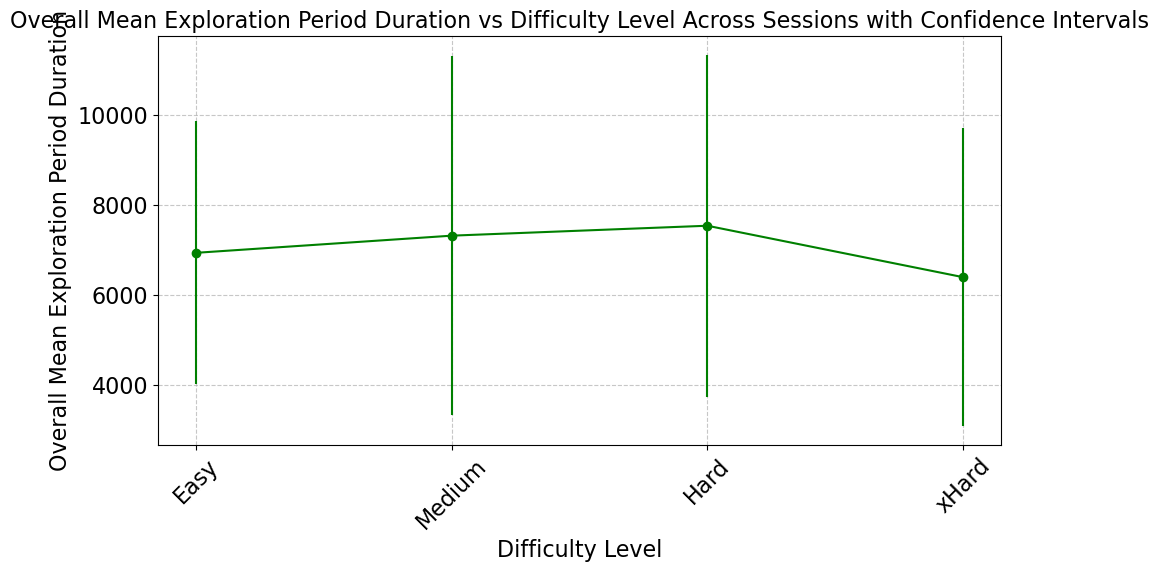

Overall Mean Exploration Period Duration per Difficulty Level Across Sessions:
difficulty
Easy      6933.163633
Medium    7314.804899
Hard      7535.735007
xHard     6391.837490
dtype: float64


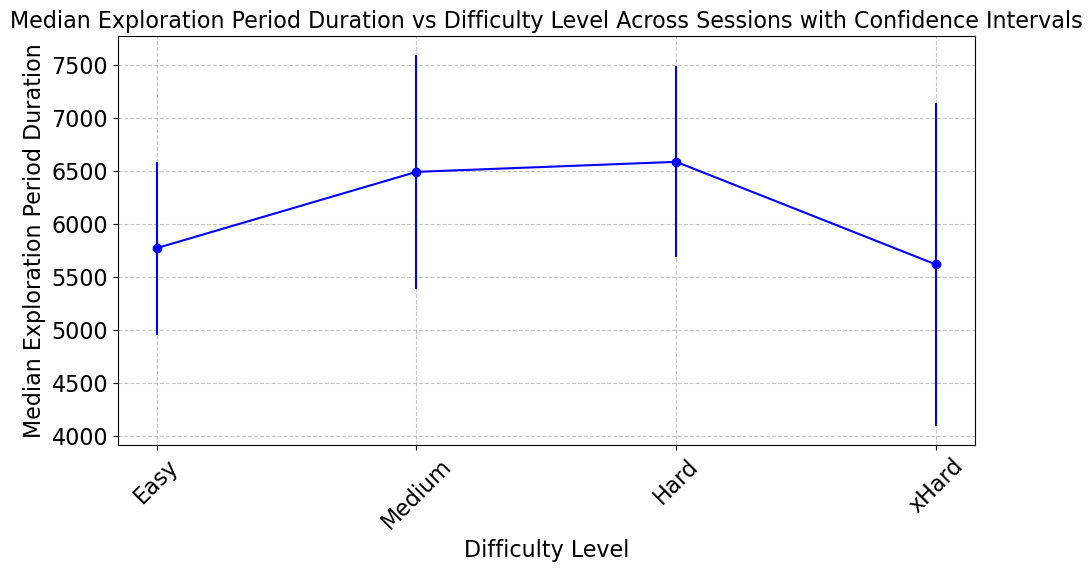


Overall Median Exploration Period Duration per Difficulty Level Across Sessions:
difficulty
Easy      5772.885714
Medium    6492.333333
Hard      6586.872340
xHard     5618.473684
dtype: float64


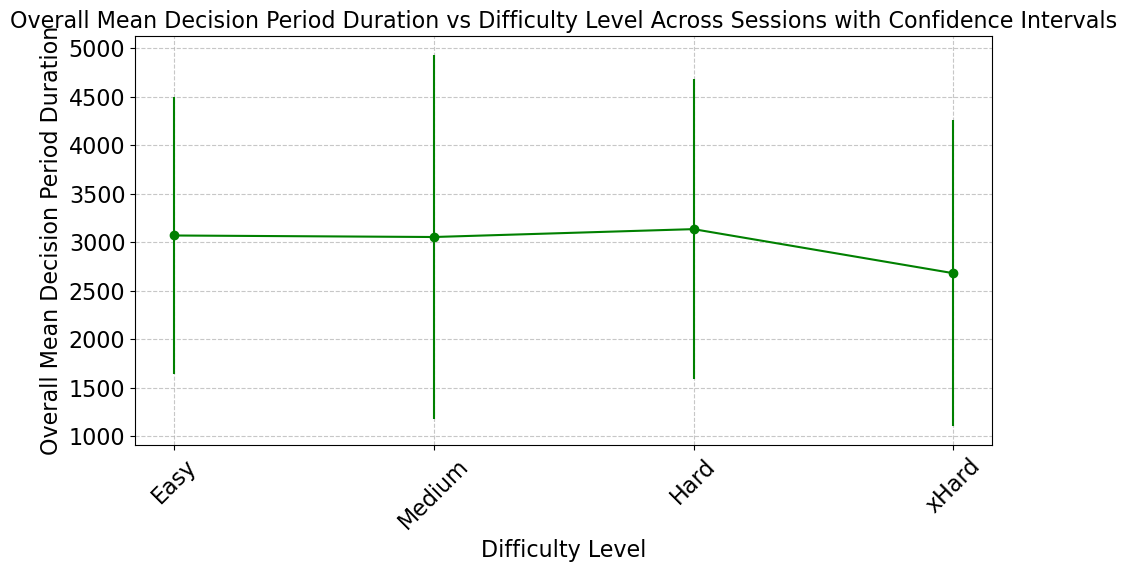

Overall Mean Decision Period Duration per Difficulty Level Across Sessions:
difficulty
Easy      3069.358662
Medium    3053.699556
Hard      3134.962838
xHard     2680.047857
dtype: float64


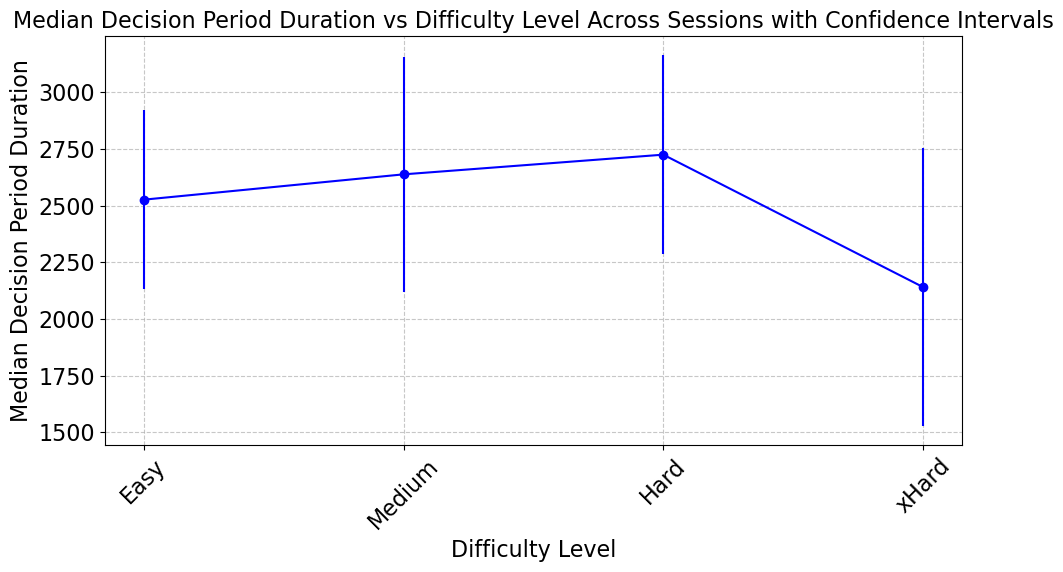


Overall Median Decision Period Duration per Difficulty Level Across Sessions:
difficulty
Easy      2526.115942
Medium    2637.830986
Hard      2724.680851
xHard     2140.600000
dtype: float64


In [10]:
# Means and medians across sessions (first session by session, then medians/ means of that)

session_mean_exp_period = exploration_data.groupby(['session', 'difficulty'])['durPeriodTotal'].mean().unstack()
session_median_exp_period = exploration_data.groupby(['session', 'difficulty'])['durPeriodTotal'].median().unstack()

overall_mean_exp_period = session_mean_exp_period.mean()
overall_median_exp_period = session_median_exp_period.mean()

overall_mean_exp_period = overall_mean_exp_period.reindex(difficulty_order)
overall_median_exp_period = overall_median_exp_period.reindex(difficulty_order)

session_std_exp_period = exploration_data.groupby(['session', 'difficulty'])['durPeriodTotal'].std().unstack()
session_count_exp_period = exploration_data.groupby(['session', 'difficulty'])['durPeriodTotal'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_period.mean() / np.sqrt(session_count_exp_period.mean())

overall_conf_interval_median = 1.96 * session_median_exp_period.std() / np.sqrt(session_median_exp_period.count())

# Increase font size globally
plt.rcParams.update({'font.size': 16})

# Mean exploration period duration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_exp_period.index, overall_mean_exp_period.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Exploration Period Duration')
plt.title('Overall Mean Exploration Period Duration vs Difficulty Level Across Sessions with Confidence Intervals', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=16)
plt.ylabel('Overall Mean Exploration Period Duration', fontsize=16)
#plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Overall Mean Exploration Period Duration per Difficulty Level Across Sessions:")
print(overall_mean_exp_period)

# Median exploration period duration sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_period.index, overall_median_exp_period.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Median Exploration Period Duration')
plt.title('Median Exploration Period Duration vs Difficulty Level Across Sessions with Confidence Intervals', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=16)
plt.ylabel('Median Exploration Period Duration', fontsize=16)
#plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nOverall Median Exploration Period Duration per Difficulty Level Across Sessions:")
print(overall_median_exp_period)

session_mean_dec_period = decision_data.groupby(['session', 'difficulty'])['durPeriodTotal'].mean().unstack()
session_median_dec_period = decision_data.groupby(['session', 'difficulty'])['durPeriodTotal'].median().unstack()

overall_mean_dec_period = session_mean_dec_period.mean()
overall_median_dec_period = session_median_dec_period.mean()

overall_mean_dec_period = overall_mean_dec_period.reindex(difficulty_order)
overall_median_dec_period = overall_median_dec_period.reindex(difficulty_order)

session_std_dec_period = decision_data.groupby(['session', 'difficulty'])['durPeriodTotal'].std().unstack()
session_count_dec_period = decision_data.groupby(['session', 'difficulty'])['durPeriodTotal'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_dec_period.mean() / np.sqrt(session_count_dec_period.mean())

overall_conf_interval_median = 1.96 * session_median_dec_period.std() / np.sqrt(session_median_dec_period.count())

# Mean decision period duration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_dec_period.index, overall_mean_dec_period.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Decision Period Duration')
plt.title('Overall Mean Decision Period Duration vs Difficulty Level Across Sessions with Confidence Intervals', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=16)
plt.ylabel('Overall Mean Decision Period Duration', fontsize=16)
#plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Overall Mean Decision Period Duration per Difficulty Level Across Sessions:")
print(overall_mean_dec_period)

# Median decision period duration sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_period.index, overall_median_dec_period.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Median Decision Period Duration')
plt.title('Median Decision Period Duration vs Difficulty Level Across Sessions with Confidence Intervals', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=16)
plt.ylabel('Median Decision Period Duration', fontsize=16)
#plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nOverall Median Decision Period Duration per Difficulty Level Across Sessions:")
print(overall_median_dec_period)

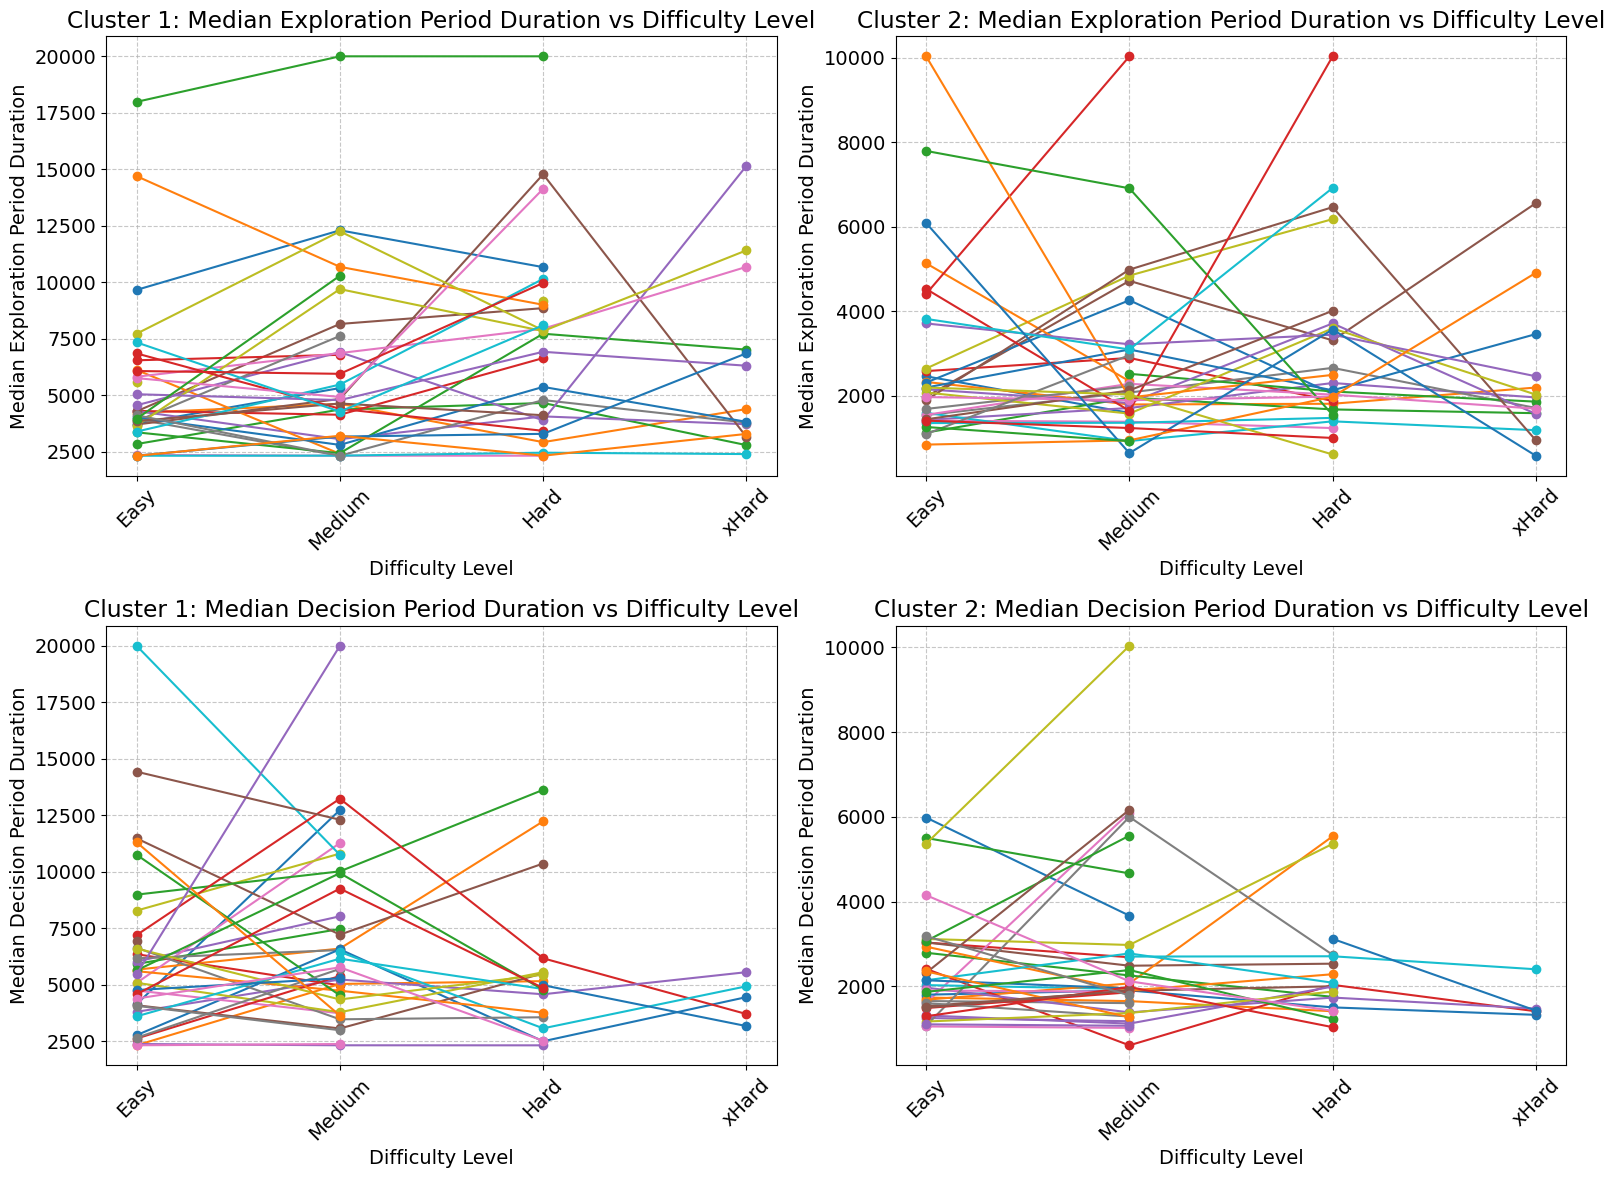

In [13]:
# Duration of both exploration and decision periods vs. difficulty level per session

exploration_grouped = data[data['period_in_trial'] == 'exploration'].groupby(['session', 'difficulty'])['durPeriodTotal'].median().unstack()
decision_grouped = data[data['period_in_trial'] == 'decision'].groupby(['session', 'difficulty'])['durPeriodTotal'].median().unstack()

exploration_mean_grouped = data[data['period_in_trial'] == 'exploration'].groupby(['session', 'difficulty'])['durPeriodTotal'].mean().unstack()
decision_mean_grouped = data[data['period_in_trial'] == 'decision'].groupby(['session', 'difficulty'])['durPeriodTotal'].mean().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE040a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE076a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

difficulty_order = ['Easy', 'Medium', 'Hard', 'xHard']

# Increase font size globally
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Sessions Cluster 1: Median duration of exploration period per session
axs[0, 0].set_title('Cluster 1: Median Exploration Period Duration vs Difficulty Level')
for session in sessions_cluster_1:
    if session in exploration_grouped.index.get_level_values('session').unique():
        duration_session_exploration = exploration_grouped.loc[session][difficulty_order]
        axs[0, 0].plot(duration_session_exploration.index, duration_session_exploration, marker='o', linestyle='-', label=f'Session {session}')
axs[0, 0].set_xlabel('Difficulty Level')
axs[0, 0].set_ylabel('Median Exploration Period Duration')
axs[0, 0].grid(True, linestyle='--', alpha=0.7)
axs[0, 0].tick_params(axis='x', rotation=45, labelsize=14)
axs[0, 0].tick_params(axis='y', labelsize=14)
#axs[0, 0].legend()

# Sessions Cluster 1: Median duration of decision period per session
axs[1, 0].set_title('Cluster 1: Median Decision Period Duration vs Difficulty Level')
for session in sessions_cluster_1:
    if session in decision_grouped.index.get_level_values('session').unique():
        duration_session_decision = decision_grouped.loc[session][difficulty_order]
        axs[0, 1].plot(duration_session_decision.index, duration_session_decision, marker='o', linestyle='-', label=f'Session {session}')
axs[1, 0].set_xlabel('Difficulty Level')
axs[1, 0].set_ylabel('Median Decision Period Duration')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)
axs[1, 0].tick_params(axis='x', rotation=45, labelsize=14)
axs[1, 0].tick_params(axis='y', labelsize=14)
#axs[1, 0].legend()

# Sessions Cluster 2: Median duration of exploration period per session
axs[0, 1].set_title('Cluster 2: Median Exploration Period Duration vs Difficulty Level')
for session in sessions_cluster_2:
    if session in exploration_grouped.index.get_level_values('session').unique():
        duration_session_exploration = exploration_grouped.loc[session][difficulty_order]
        axs[1, 0].plot(duration_session_exploration.index, duration_session_exploration, marker='o', linestyle='-', label=f'Session {session}')
axs[0, 1].set_xlabel('Difficulty Level')
axs[0, 1].set_ylabel('Median Exploration Period Duration')
axs[0, 1].grid(True, linestyle='--', alpha=0.7)
axs[0, 1].tick_params(axis='x', rotation=45, labelsize=14)
axs[0, 1].tick_params(axis='y', labelsize=14)
#axs[0, 1].legend()

# Sessions Cluster 2: Median duration of decision period per session
axs[1, 1].set_title('Cluster 2: Median Decision Period Duration vs Difficulty Level')
for session in sessions_cluster_2:
    if session in decision_grouped.index.get_level_values('session').unique():
        duration_session_decision = decision_grouped.loc[session][difficulty_order]
        axs[1, 1].plot(duration_session_decision.index, duration_session_decision, marker='o', linestyle='-', label=f'Session {session}')
axs[1, 1].set_xlabel('Difficulty Level')
axs[1, 1].set_ylabel('Median Decision Period Duration')
axs[1, 1].grid(True, linestyle='--', alpha=0.7)
axs[1, 1].tick_params(axis='x', rotation=45, labelsize=14)
axs[1, 1].tick_params(axis='y', labelsize=14)
#axs[1, 1].legend()

plt.tight_layout()
plt.show()


## Number of fixations of bottom cards during exploration vs. Difficulty level

Shapiro-Wilk test for Easy: p-value = 1.2199125043244308e-24
Shapiro-Wilk test for Hard: p-value = 1.0372645600208383e-12
Shapiro-Wilk test for Medium: p-value = 1.990782237906419e-19
Shapiro-Wilk test for xHard: p-value = 2.2291711090478103e-12
Levene's test for homogeneity of variances: p-value = 0.5779523463717791
Kruskal-Wallis test:
H-statistic: 7.442825640280205
p-value: 0.059045848033239916


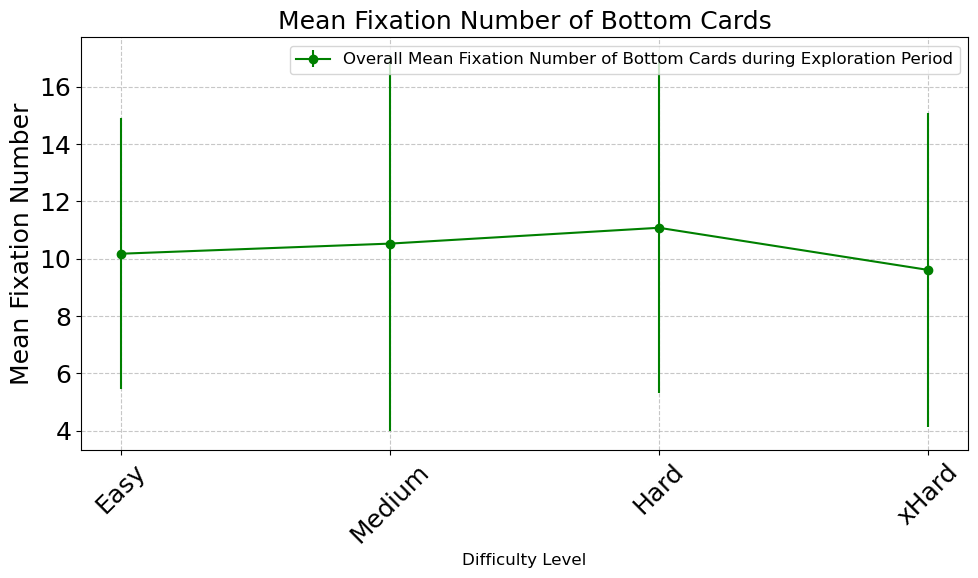

Overall Mean Fixation Number of Bottom Cards during Exploration Period per Difficulty Level Across Sessions:
difficulty
Easy      10.175363
Medium    10.528014
Hard      11.079847
xHard      9.612182
dtype: float64


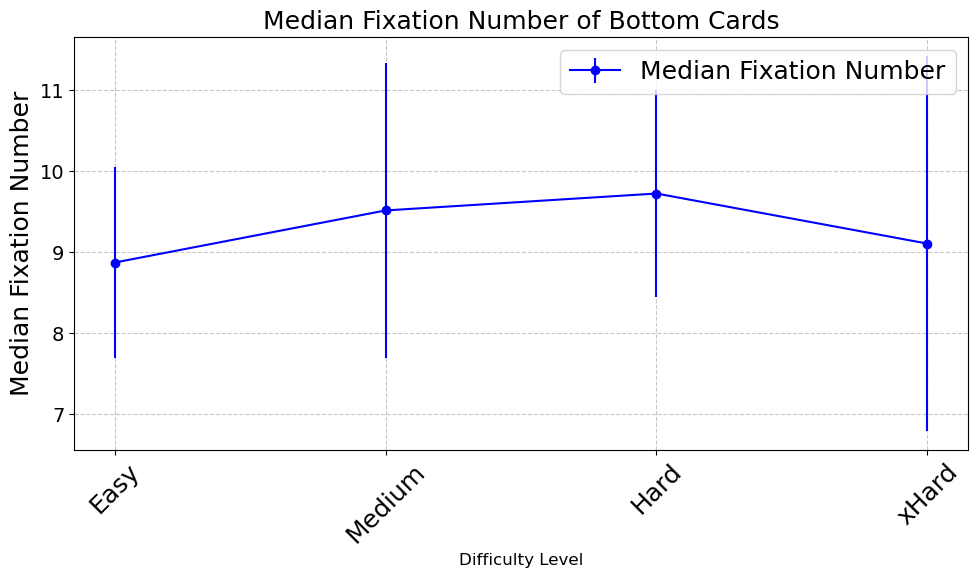


Overall Median Fixation Number of Bottom Cards during Exploration Period per Difficulty Level Across Sessions:
difficulty
Easy      8.871429
Medium    9.514493
Hard      9.723404
xHard     9.105263
dtype: float64


In [39]:
# Means and medians across sessions (first session by session, then medians/ means of that)

FixNbInBottom_by_difficulty = [exploration_data[exploration_data['difficulty'] == level]['FixNbInBottom'] for level in exploration_data['difficulty'].unique()]

# Shapiro-Wilk test for normality
for group_name, group_data in exploration_data.groupby('difficulty')['FixNbInBottom']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*FixNbInBottom_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*FixNbInBottom_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_exp_FixNbInBottom = exploration_data.groupby(['session', 'difficulty'])['FixNbInBottom'].mean().unstack()
session_median_exp_FixNbInBottom = exploration_data.groupby(['session', 'difficulty'])['FixNbInBottom'].median().unstack()

overall_mean_exp_FixNbInBottom = session_mean_exp_FixNbInBottom.mean()
overall_median_exp_FixNbInBottom = session_median_exp_FixNbInBottom.mean()

overall_mean_exp_FixNbInBottom = overall_mean_exp_FixNbInBottom.reindex(difficulty_order)
overall_median_exp_FixNbInBottom = overall_median_exp_FixNbInBottom.reindex(difficulty_order)

session_std_exp_FixNbInBottom = exploration_data.groupby(['session', 'difficulty'])['FixNbInBottom'].std().unstack()
session_count_exp_FixNbInBottom = exploration_data.groupby(['session', 'difficulty'])['FixNbInBottom'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_FixNbInBottom.mean() / np.sqrt(session_count_exp_FixNbInBottom.mean())

overall_conf_interval_median = 1.96 * session_median_exp_FixNbInBottom.std() / np.sqrt(session_median_exp_FixNbInBottom.count())

# Mean exploration fixation number of bottom cards across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_exp_FixNbInBottom.index, overall_mean_exp_FixNbInBottom.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Fixation Number of Bottom Cards during Exploration Period')
plt.title('Mean Fixation Number of Bottom Cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=12)
plt.ylabel('Mean Fixation Number', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

print("Overall Mean Fixation Number of Bottom Cards during Exploration Period per Difficulty Level Across Sessions:")
print(overall_mean_exp_FixNbInBottom)

# Median exploration fixation number of bottom cards across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_FixNbInBottom.index, overall_median_exp_FixNbInBottom.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Median Fixation Number')
plt.title('Median Fixation Number of Bottom Cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=12)
plt.ylabel('Median Fixation Number', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Number of Bottom Cards during Exploration Period per Difficulty Level Across Sessions:")
print(overall_median_exp_FixNbInBottom)

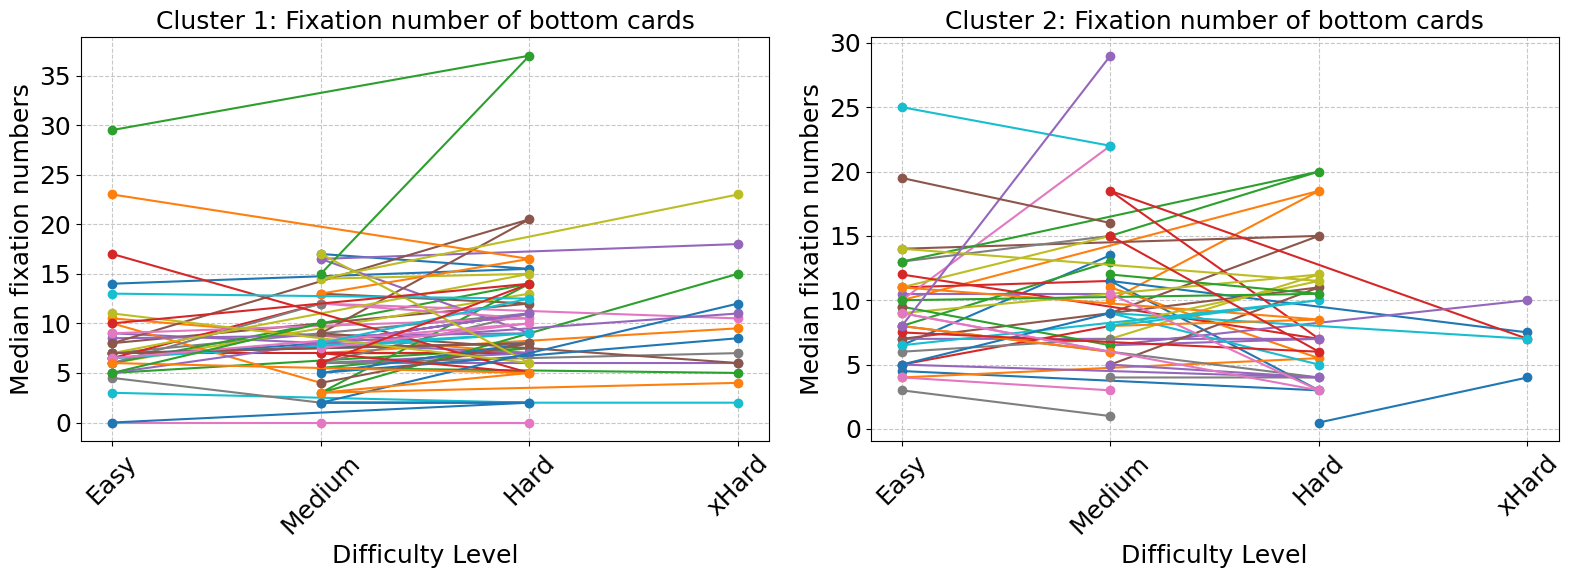

In [24]:
# Fix Number of bottom cards (exploration period) vs. difficulty level per session

#Medians
session_fix_nb_exploration = exploration_data.groupby(['session', 'difficulty'])['FixNbInBottom'].median().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.figure(figsize=(16, 6))

# Plot for Cluster 1
plt.subplot(1, 2, 1)
for session in sessions_cluster_1:
    available_difficulty_levels = session_fix_nb_exploration.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_fixnbBottom_session = session_fix_nb_exploration.loc[session][available_difficulty_levels]
        plt.plot(median_fixnbBottom_session.index, median_fixnbBottom_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 1: Fixation number of bottom cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median fixation numbers', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend()

# Plot for Cluster 2
plt.subplot(1, 2, 2)
for session in sessions_cluster_2:
    available_difficulty_levels = session_fix_nb_exploration.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_fixnbBottom_session = session_fix_nb_exploration.loc[session][available_difficulty_levels]
        plt.plot(median_fixnbBottom_session.index, median_fixnbBottom_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 2: Fixation number of bottom cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median fixation numbers', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend()

plt.tight_layout()
plt.show()

## Number of fixations of top card (decision period) vs. Difficulty level

Shapiro-Wilk test for Easy: p-value = 8.491829042694057e-26
Shapiro-Wilk test for Hard: p-value = 3.865973222451638e-16
Shapiro-Wilk test for Medium: p-value = 2.9442091776032876e-23
Shapiro-Wilk test for xHard: p-value = 1.51097390774812e-11
Levene's test for homogeneity of variances: p-value = 0.3468712000770811
Kruskal-Wallis test:
H-statistic: 2.308967646938908
p-value: 0.5108051211553273


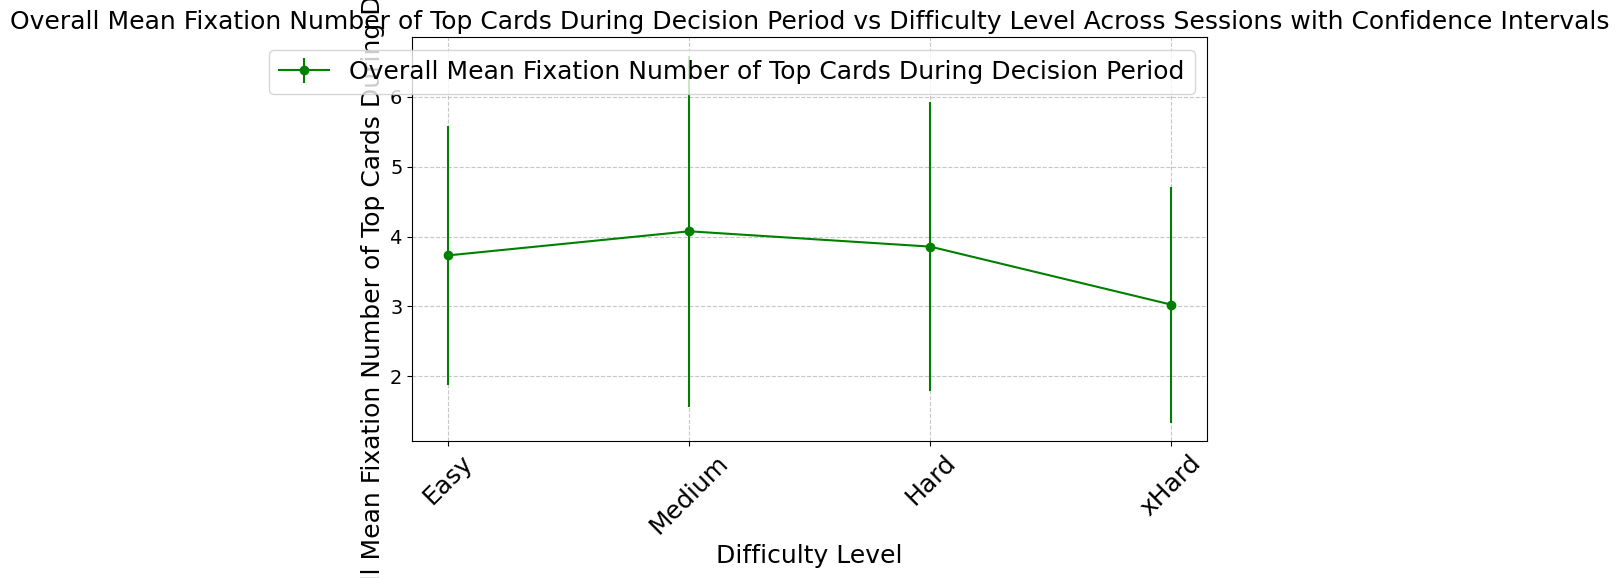

Overall Mean Fixation Number of Top Cards During Decision Period per Difficulty Level Across Sessions:
difficulty
Easy      3.730543
Medium    4.075116
Hard      3.856020
xHard     3.025635
dtype: float64


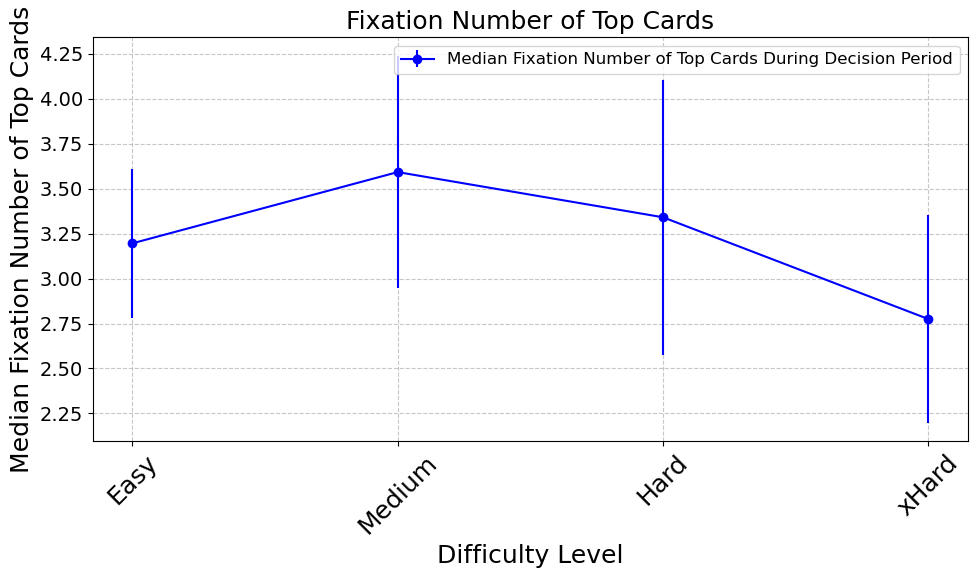


Overall Median Fixation Number of Top Cards During Decision Period per Difficulty Level Across Sessions:
difficulty
Easy      3.195652
Medium    3.591549
Hard      3.340426
xHard     2.775000
dtype: float64


In [27]:
# Means and medians across sessions (first session by session, then medians/ means of that)

FixNbInt_by_difficulty = [decision_data[decision_data['difficulty'] == level]['FixNbInT'] for level in decision_data['difficulty'].unique()]

# Shapiro-Wilk test for normality
for group_name, group_data in decision_data.groupby('difficulty')['FixNbInT']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*FixNbInt_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*FixNbInt_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_dec_FixNbInT = decision_data.groupby(['session', 'difficulty'])['FixNbInT'].mean().unstack()
session_median_dec_FixNbInT = decision_data.groupby(['session', 'difficulty'])['FixNbInT'].median().unstack()

overall_mean_dec_FixNbInT = session_mean_dec_FixNbInT.mean()
overall_median_dec_FixNbInT = session_median_dec_FixNbInT.mean()

overall_mean_dec_FixNbInT = overall_mean_dec_FixNbInT.reindex(difficulty_order)
overall_median_dec_FixNbInT = overall_median_dec_FixNbInT.reindex(difficulty_order)

session_std_dec_FixNbInT = decision_data.groupby(['session', 'difficulty'])['FixNbInT'].std().unstack()
session_count_dec_FixNbInT = decision_data.groupby(['session', 'difficulty'])['FixNbInT'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_dec_FixNbInT.mean() / np.sqrt(session_count_dec_FixNbInT.mean())

overall_conf_interval_median = 1.96 * session_median_dec_FixNbInT.std() / np.sqrt(session_median_dec_FixNbInT.count())

# Mean FixNbInT during decision period across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_dec_FixNbInT.index, overall_mean_dec_FixNbInT.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Fixation Number of Top Cards During Decision Period')
plt.title('Overall Mean Fixation Number of Top Cards During Decision Period vs Difficulty Level Across Sessions with Confidence Intervals', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Overall Mean Fixation Number of Top Cards During Decision Period', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.tight_layout()
plt.show()

print("Overall Mean Fixation Number of Top Cards During Decision Period per Difficulty Level Across Sessions:")
print(overall_mean_dec_FixNbInT)

# Median FixNbInT during decision period across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixNbInT.index, overall_median_dec_FixNbInT.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Median Fixation Number of Top Cards During Decision Period')
plt.title('Fixation Number of Top Cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Fixation Number of Top Cards', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Number of Top Cards During Decision Period per Difficulty Level Across Sessions:")
print(overall_median_dec_FixNbInT)

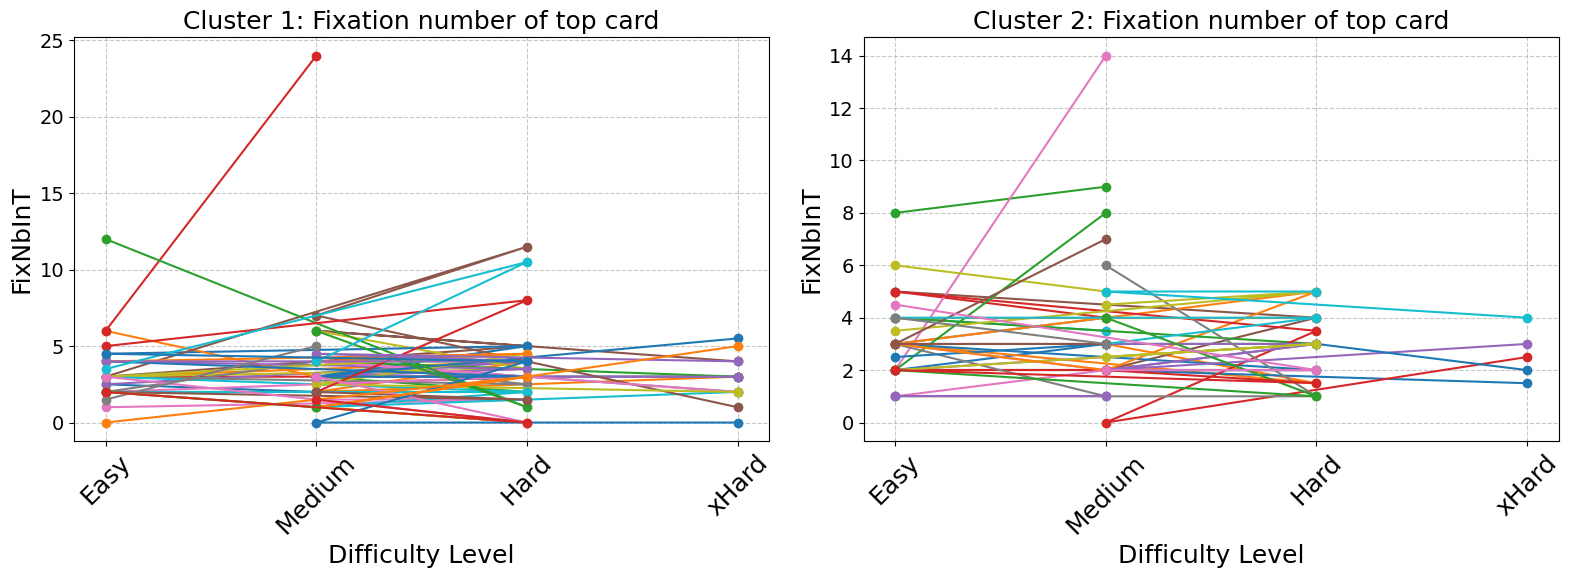

In [29]:
# Fixation number of top card (decision period) vs. difficulty levels per session

#Medians
session_FixNbInT_decision = decision_data.groupby(['session', 'difficulty'])['FixNbInT'].median().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.figure(figsize=(16, 6))

# Sessions Cluster 1
plt.subplot(1, 2, 1)
for session in sessions_cluster_1:
    available_difficulty_levels = session_FixNbInT_decision.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_FixNbInT_session = session_FixNbInT_decision.loc[session][available_difficulty_levels]
        plt.plot(median_FixNbInT_session.index, median_FixNbInT_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 1: Fixation number of top card', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('FixNbInT', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
#plt.legend()

# Sessions Cluster 2
plt.subplot(1, 2, 2)
for session in sessions_cluster_2:
    available_difficulty_levels = session_FixNbInT_decision.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_FixNbInT_session = session_FixNbInT_decision.loc[session][available_difficulty_levels]
        plt.plot(median_FixNbInT_session.index, median_FixNbInT_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 2: Fixation number of top card', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('FixNbInT', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
#plt.legend()

plt.tight_layout()
plt.show()

## Fixation Duration of Top Card (Decision Period) vs. Difficulty Level

Shapiro-Wilk test for Easy: p-value = 1.1039896437604597e-25
Shapiro-Wilk test for Hard: p-value = 1.1753390214624306e-15
Shapiro-Wilk test for Medium: p-value = 9.384263269349936e-21
Shapiro-Wilk test for xHard: p-value = 3.0918286707949423e-11
Levene's test for homogeneity of variances: p-value = 0.19335010953479043
Kruskal-Wallis test:
H-statistic: 2.504631164871994
p-value: 0.47445470952784374


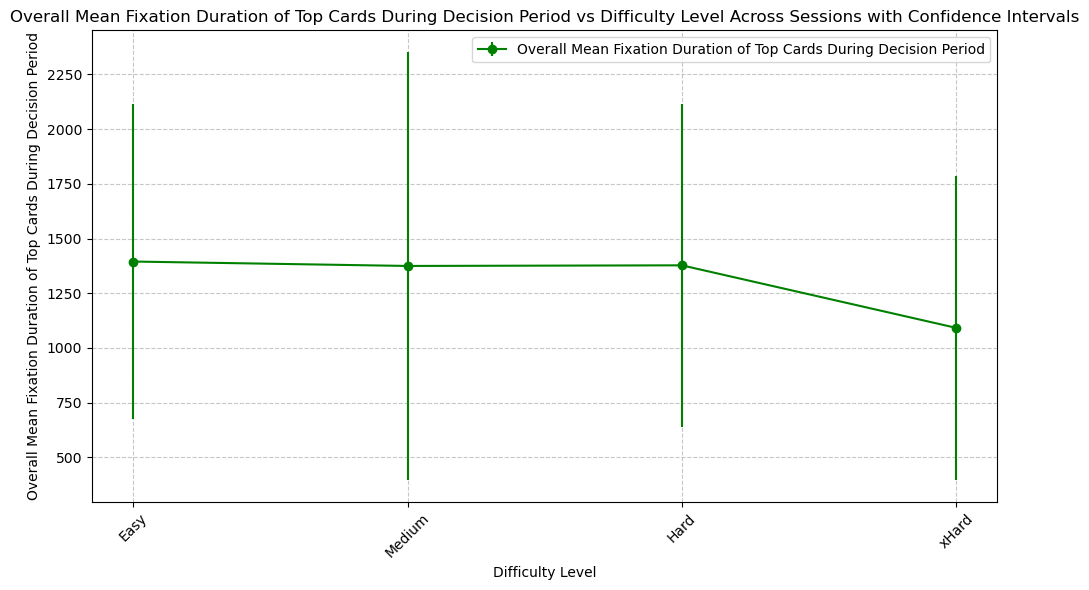

Overall Mean Fixation Duration of Top Cards During Decision Period per Difficulty Level Across Sessions:
difficulty
Easy      1394.842287
Medium    1374.665248
Hard      1377.536896
xHard     1091.907063
dtype: float64


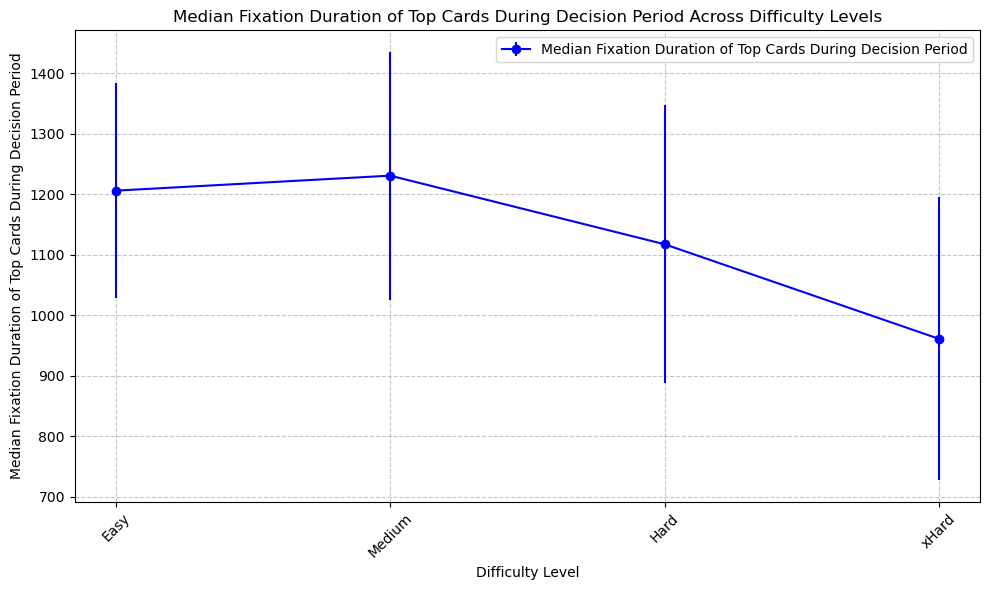


Overall Median Fixation Duration of Top Cards During Decision Period per Difficulty Level Across Sessions:
difficulty
Easy      1205.985507
Medium    1230.760563
Hard      1117.489362
xHard      961.300000
dtype: float64


In [32]:
# Means and medians across sessions (first session by session, then medians/ means of that)
difficulty_order = ['Easy', 'Medium', 'Hard', 'xHard']

FixTotDurInT_by_difficulty = [decision_data[decision_data['difficulty'] == level]['FixTotDurInT'] for level in decision_data['difficulty'].unique()]

# Shapiro-Wilk test for normality
for group_name, group_data in decision_data.groupby('difficulty')['FixTotDurInT']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*FixTotDurInT_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*FixTotDurInT_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_dec_FixTotDurInT = decision_data.groupby(['session', 'difficulty'])['FixTotDurInT'].mean().unstack()
session_median_dec_FixTotDurInT = decision_data.groupby(['session', 'difficulty'])['FixTotDurInT'].median().unstack()

overall_mean_dec_FixTotDurInT = session_mean_dec_FixTotDurInT.mean()
overall_median_dec_FixTotDurInT = session_median_dec_FixTotDurInT.mean()

overall_mean_dec_FixTotDurInT = overall_mean_dec_FixTotDurInT.reindex(difficulty_order)
overall_median_dec_FixTotDurInT = overall_median_dec_FixTotDurInT.reindex(difficulty_order)

session_std_dec_FixTotDurInT = decision_data.groupby(['session', 'difficulty'])['FixTotDurInT'].std().unstack()
session_count_dec_FixTotDurInT = decision_data.groupby(['session', 'difficulty'])['FixTotDurInT'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_dec_FixTotDurInT.mean() / np.sqrt(session_count_dec_FixTotDurInT.mean())

overall_conf_interval_median = 1.96 * session_median_dec_FixTotDurInT.std() / np.sqrt(session_median_dec_FixTotDurInT.count())

# Mean FixTotDurInT during decision period across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_dec_FixTotDurInT.index, overall_mean_dec_FixTotDurInT.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Fixation Duration of Top Cards During Decision Period')
plt.title('Overall Mean Fixation Duration of Top Cards During Decision Period vs Difficulty Level Across Sessions with Confidence Intervals')
plt.xlabel('Difficulty Level')
plt.ylabel('Overall Mean Fixation Duration of Top Cards During Decision Period')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Overall Mean Fixation Duration of Top Cards During Decision Period per Difficulty Level Across Sessions:")
print(overall_mean_dec_FixTotDurInT)

# Median FixTotDurInT during decision period across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_dec_FixTotDurInT.index, overall_median_dec_FixTotDurInT.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Median Fixation Duration of Top Cards During Decision Period')
plt.title('Median Fixation Duration of Top Cards During Decision Period Across Difficulty Levels')
plt.xlabel('Difficulty Level')
plt.ylabel('Median Fixation Duration of Top Cards During Decision Period')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Duration of Top Cards During Decision Period per Difficulty Level Across Sessions:")
print(overall_median_dec_FixTotDurInT)

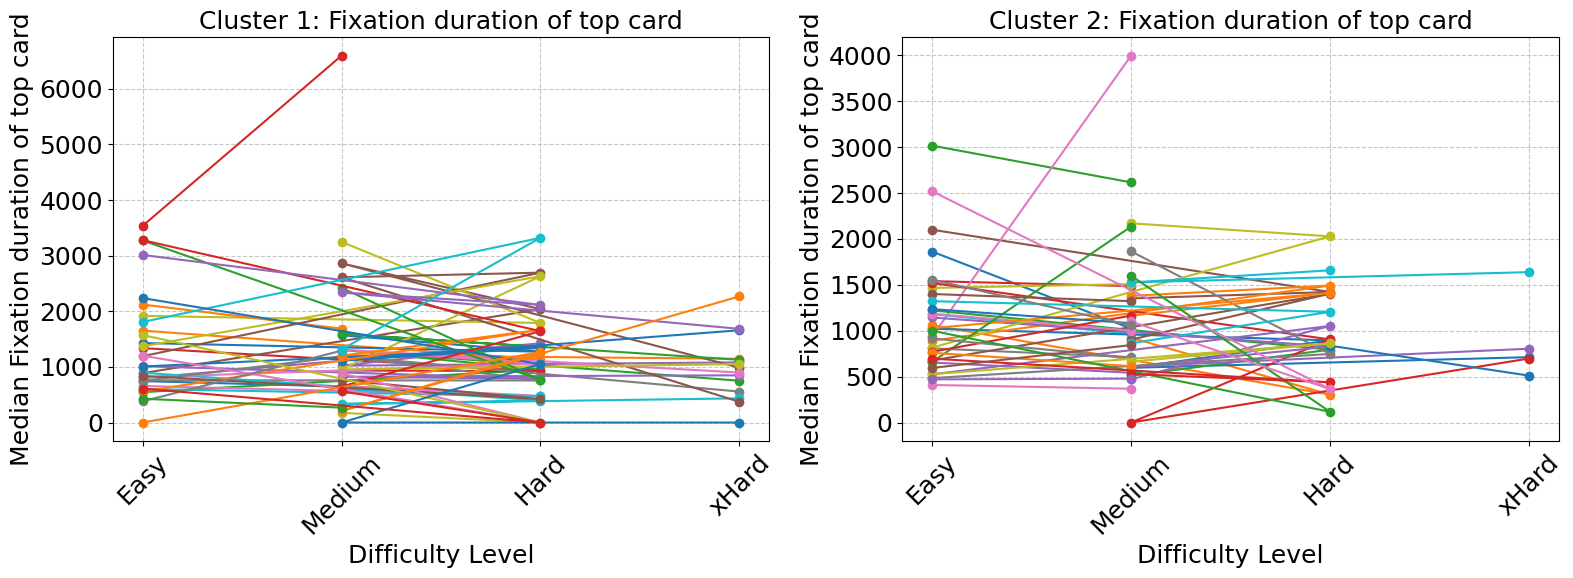

In [20]:
# Fixation duration of top card (decision period) vs. difficulty levels per session

session_FixTotDurInT_decision = decision_data.groupby(['session', 'difficulty'])['FixTotDurInT'].median().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.figure(figsize=(16, 6))

# Sessions Cluster 1
plt.subplot(1, 2, 1)
for session in sessions_cluster_1:
    available_difficulty_levels = session_FixTotDurInT_decision.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_FixTotDurInT_session = session_FixTotDurInT_decision.loc[session][available_difficulty_levels]
        plt.plot(median_FixTotDurInT_session.index, median_FixTotDurInT_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 1: Fixation duration of top card', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Fixation duration of top card', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend()

# Sessions Cluster 2
plt.subplot(1, 2, 2)
for session in sessions_cluster_2:
    available_difficulty_levels = session_FixTotDurInT_decision.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_FixTotDurInT_session = session_FixTotDurInT_decision.loc[session][available_difficulty_levels]
        plt.plot(median_FixTotDurInT_session.index, median_FixTotDurInT_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 2: Fixation duration of top card', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Fixation duration of top card', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend()

plt.tight_layout()
plt.show()

## Fixation Duration of Bottom Cards (Exploration Period) vs. Difficulty Level

Shapiro-Wilk test for Easy: p-value = 8.595359793953724e-25
Shapiro-Wilk test for Hard: p-value = 7.378313586658107e-14
Shapiro-Wilk test for Medium: p-value = 5.504897074628736e-19
Shapiro-Wilk test for xHard: p-value = 4.725917002485107e-13
Levene's test for homogeneity of variances: p-value = 0.32301008245733914
Kruskal-Wallis test:
H-statistic: 9.435134670479917
p-value: 0.024031525711309447


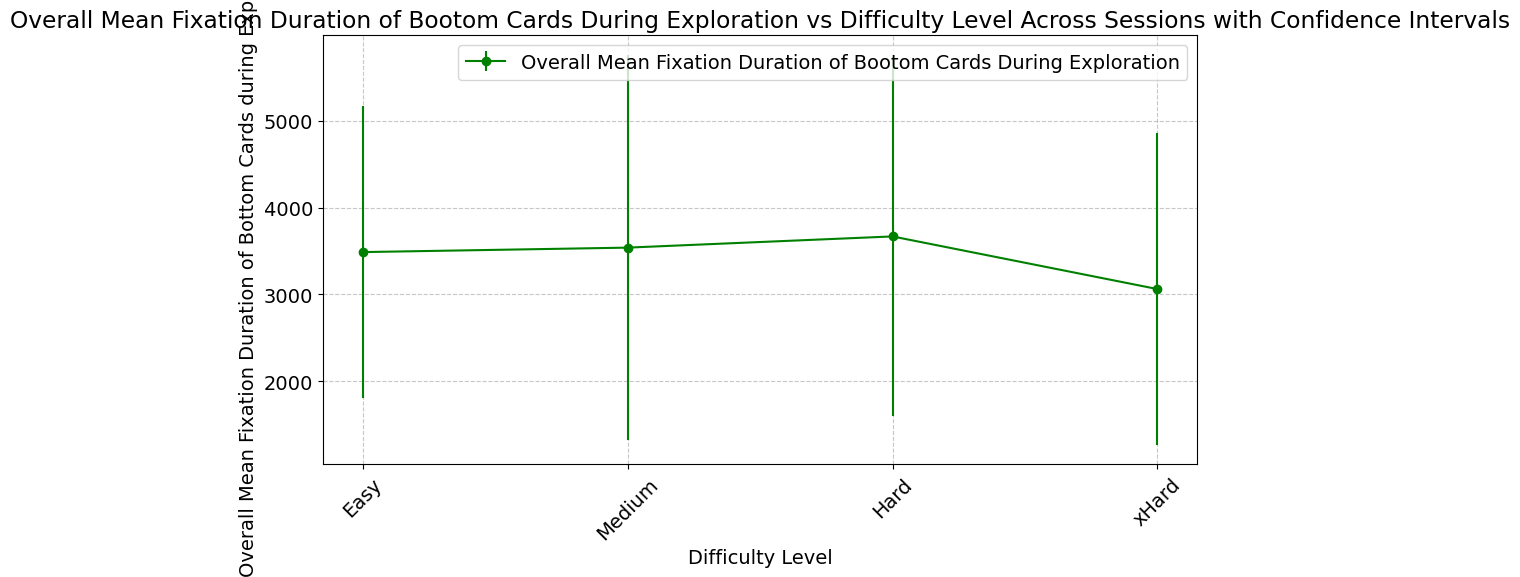

Overall Mean Fixation Duration of Bootom Cards During Exploration per Difficulty Level Across Sessions:
difficulty
Easy      3488.060745
Medium    3539.539806
Hard      3668.577508
xHard     3062.020220
dtype: float64


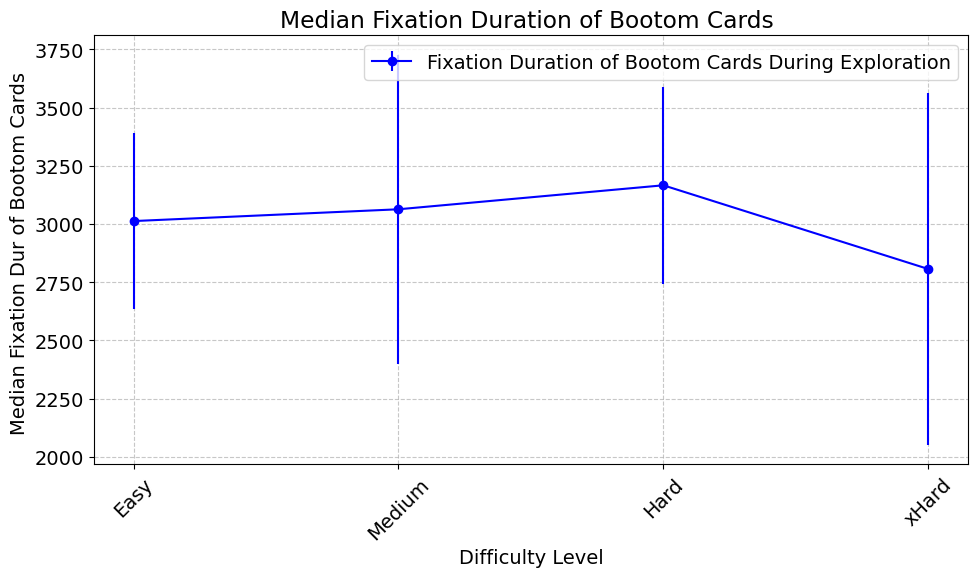


Overall Median Fixation Duration of Bootom Cards During Exploration per Difficulty Level Across Sessions:
difficulty
Easy      3012.471429
Medium    3063.101449
Hard      3166.170213
xHard     2806.473684
dtype: float64


In [16]:
# Means and medians across sessions (first session by session, then medians/ means of that)

durfixBottom_by_difficulty = [exploration_data[exploration_data['difficulty'] == level]['durfixBottom'] for level in exploration_data['difficulty'].unique()]

# Shapiro-Wilk test for normality
for group_name, group_data in exploration_data.groupby('difficulty')['durfixBottom']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*durfixBottom_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*durfixBottom_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_exp_durfixBottom = exploration_data.groupby(['session', 'difficulty'])['durfixBottom'].mean().unstack()
session_median_exp_durfixBottom = exploration_data.groupby(['session', 'difficulty'])['durfixBottom'].median().unstack()

overall_mean_exp_durfixBottom = session_mean_exp_durfixBottom.mean()
overall_median_exp_durfixBottom = session_median_exp_durfixBottom.mean()

overall_mean_exp_durfixBottom = overall_mean_exp_durfixBottom.reindex(difficulty_order)
overall_median_exp_durfixBottom = overall_median_exp_durfixBottom.reindex(difficulty_order)

session_std_exp_durfixBottom = exploration_data.groupby(['session', 'difficulty'])['durfixBottom'].std().unstack()
session_count_exp_durfixBottom = exploration_data.groupby(['session', 'difficulty'])['durfixBottom'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_durfixBottom.mean() / np.sqrt(session_count_exp_durfixBottom.mean())

overall_conf_interval_median = 1.96 * session_median_exp_durfixBottom.std() / np.sqrt(session_median_exp_durfixBottom.count())

# Mean exploration fixation duration of bottom cards across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_mean_exp_durfixBottom.index, overall_mean_exp_durfixBottom.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Fixation Duration of Bootom Cards During Exploration')
plt.title('Overall Mean Fixation Duration of Bootom Cards During Exploration vs Difficulty Level Across Sessions with Confidence Intervals')
plt.xlabel('Difficulty Level')
plt.ylabel('Overall Mean Fixation Duration of Bottom Cards during Exploration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Overall Mean Fixation Duration of Bootom Cards During Exploration per Difficulty Level Across Sessions:")
print(overall_mean_exp_durfixBottom)

# Median exploration Fixation duration of bottom cards across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_durfixBottom.index, overall_median_exp_durfixBottom.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label='Fixation Duration of Bootom Cards During Exploration')
plt.title('Median Fixation Duration of Bootom Cards ')
plt.xlabel('Difficulty Level')
plt.ylabel('Median Fixation Dur of Bootom Cards ')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nOverall Median Fixation Duration of Bootom Cards During Exploration per Difficulty Level Across Sessions:")
print(overall_median_exp_durfixBottom)

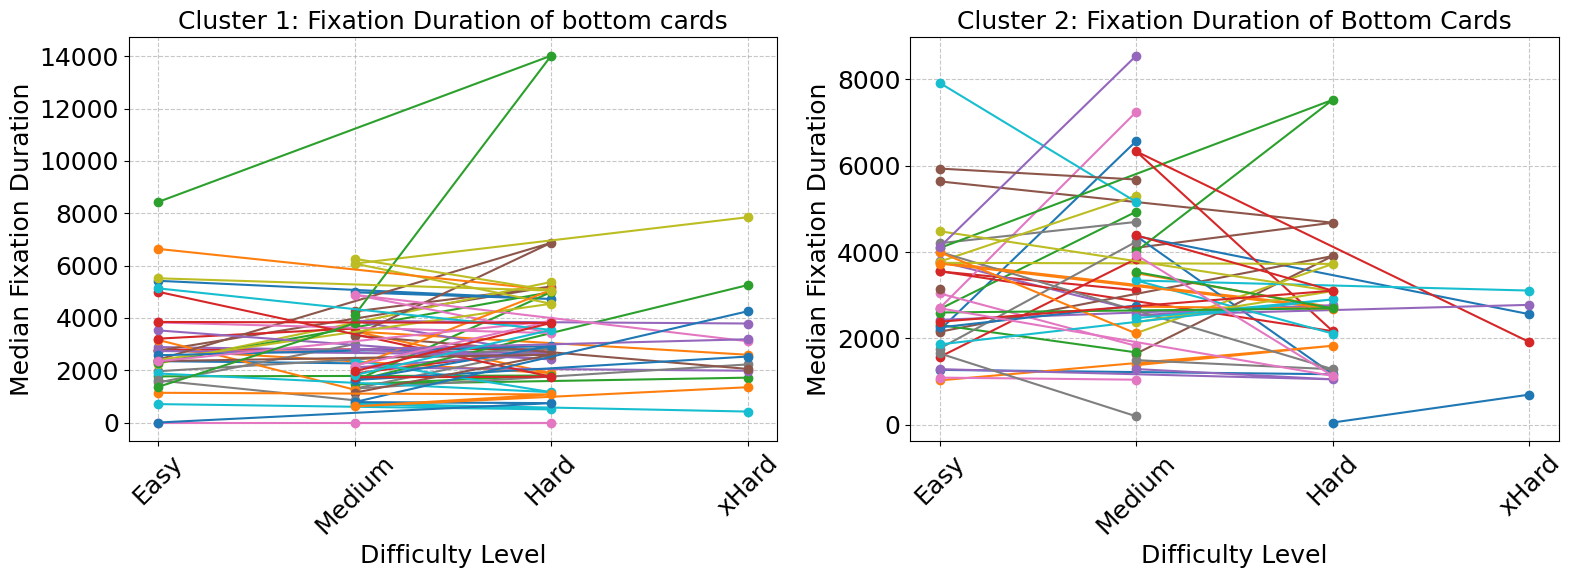

In [18]:
# durfixBottomExploration vs. difficulty per session

session_fix_dur_exploration = exploration_data.groupby(['session', 'difficulty'])['durfixBottom'].median().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.figure(figsize=(16, 6))

# Plot for Cluster 1
plt.subplot(1, 2, 1)
for session in sessions_cluster_1:
    available_difficulty_levels = session_fix_dur_exploration.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_fixdurBottom_session = session_fix_dur_exploration.loc[session][available_difficulty_levels]
        plt.plot(median_fixdurBottom_session.index, median_fixdurBottom_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 1: Fixation Duration of bottom cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Fixation Duration', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend()

# Plot for Cluster 2
plt.subplot(1, 2, 2)
for session in sessions_cluster_2:
    available_difficulty_levels = session_fix_dur_exploration.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_fixdurBottom_session = session_fix_dur_exploration.loc[session][available_difficulty_levels]
        plt.plot(median_fixdurBottom_session.index, median_fixdurBottom_session, marker='o', linestyle='-', label=f'Session {session}')

plt.title('Cluster 2: Fixation Duration of Bottom Cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Fixation Duration', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend()

plt.tight_layout()
plt.show()

## Number of Switches between bottom cards (exploration period) vs. Difficulty Level

Shapiro-Wilk test for Easy: p-value = 4.696509027301086e-24
Shapiro-Wilk test for Hard: p-value = 1.5238506710750849e-15
Shapiro-Wilk test for Medium: p-value = 7.085515852965525e-18
Shapiro-Wilk test for xHard: p-value = 1.1121631150463138e-09
Levene's test for homogeneity of variances: p-value = 0.04932657394960103
Kruskal-Wallis test:
H-statistic: 4.2826625177305715
p-value: 0.23251501069248087


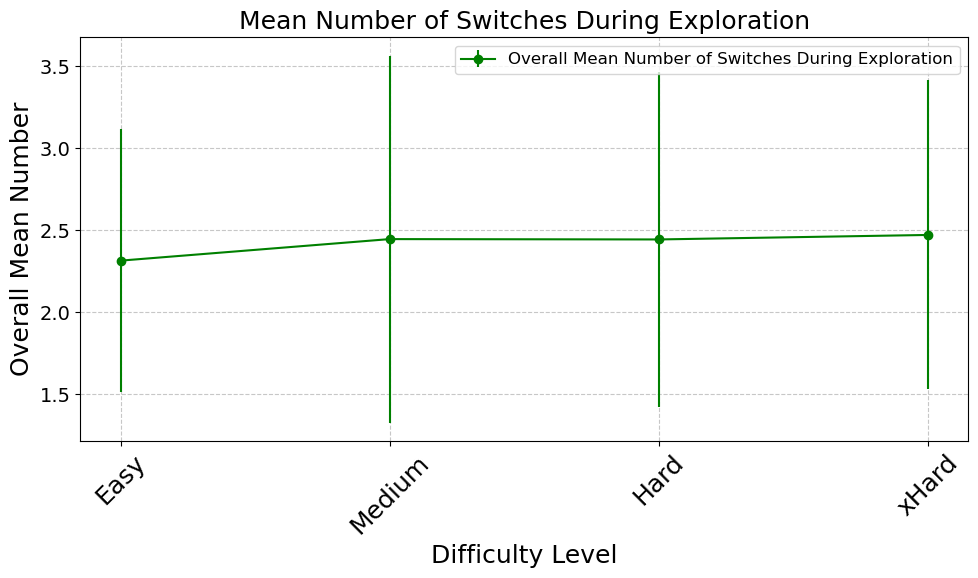

Overall Mean Number of Switches During Exploration per Difficulty Level Across Sessions:
difficulty
Easy      2.314106
Medium    2.445462
Hard      2.443311
xHard     2.470720
dtype: float64


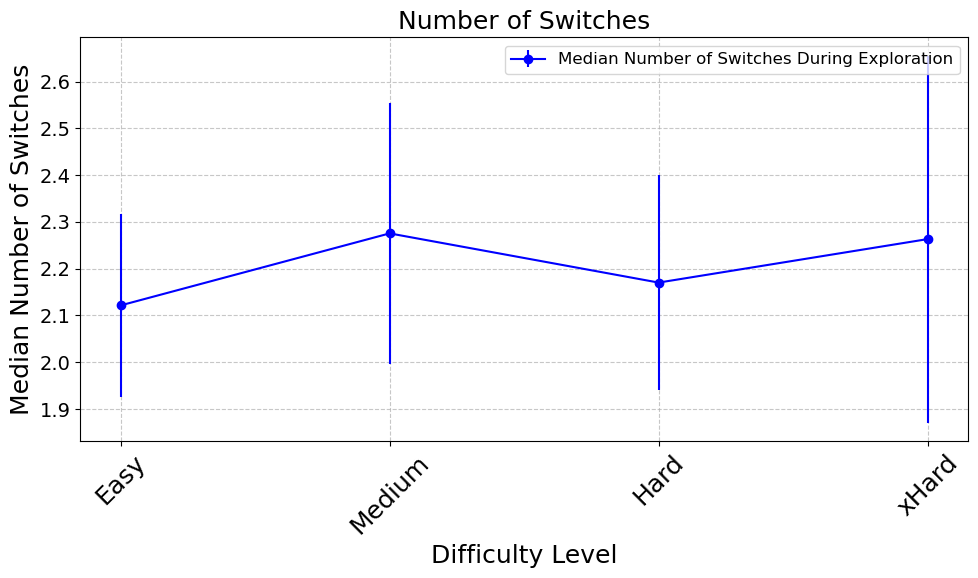


Overall Median Number of Switches During Exploration per Difficulty Level Across Sessions:
difficulty
Easy      2.121429
Medium    2.275362
Hard      2.170213
xHard     2.263158
dtype: float64


In [40]:
# Means and medians across sessions (first session by session, then medians/ means of that)

NbSwitches_by_difficulty = [exploration_data[exploration_data['difficulty'] == level]['NbSwitches'] for level in exploration_data['difficulty'].unique()]

# Shapiro-Wilk test for normality
for group_name, group_data in exploration_data.groupby('difficulty')['NbSwitches']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*NbSwitches_by_difficulty)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Based on this, I can't perform ANOVA test 

#Kruskal-Wallis test
H, p = kruskal(*NbSwitches_by_difficulty)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

session_mean_exp_NbSwitches = exploration_data.groupby(['session', 'difficulty'])['NbSwitches'].mean().unstack()
session_median_exp_NbSwitches = exploration_data.groupby(['session', 'difficulty'])['NbSwitches'].median().unstack()

overall_mean_exp_NbSwitches = session_mean_exp_NbSwitches.mean()
overall_median_exp_NbSwitches = session_median_exp_NbSwitches.mean()

overall_mean_exp_NbSwitches = overall_mean_exp_NbSwitches.reindex(difficulty_order)
overall_median_exp_NbSwitches = overall_median_exp_NbSwitches.reindex(difficulty_order)

session_std_exp_NbSwitches = exploration_data.groupby(['session', 'difficulty'])['NbSwitches'].std().unstack()
session_count_exp_NbSwitches = exploration_data.groupby(['session', 'difficulty'])['NbSwitches'].count().unstack()
overall_conf_interval_mean = 1.96 * session_std_exp_NbSwitches.mean() / np.sqrt(session_count_exp_NbSwitches.mean())

overall_conf_interval_median = 1.96 * session_median_exp_NbSwitches.std() / np.sqrt(session_median_exp_NbSwitches.count())

plt.figure(figsize=(10, 6))

# Mean exploration NbSwitches during exploration across sessions with confidence intervals
plt.errorbar(overall_mean_exp_NbSwitches.index, overall_mean_exp_NbSwitches.values, yerr=overall_conf_interval_mean, fmt='o', linestyle='-', color='green', label='Overall Mean Number of Switches During Exploration')
plt.title('Mean Number of Switches During Exploration', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Overall Mean Number', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.tight_layout()
plt.show()

print("Overall Mean Number of Switches During Exploration per Difficulty Level Across Sessions:")
print(overall_mean_exp_NbSwitches)

# Median NbSwitches during exploration across sessions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(overall_median_exp_NbSwitches.index, overall_median_exp_NbSwitches.values, yerr=overall_conf_interval_median, fmt='o', linestyle='-', color='blue', label= 'Median Number of Switches During Exploration')
plt.title('Number of Switches', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Number of Switches', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
plt.tight_layout()
plt.show()

print("\nOverall Median Number of Switches During Exploration per Difficulty Level Across Sessions:")
print(overall_median_exp_NbSwitches)

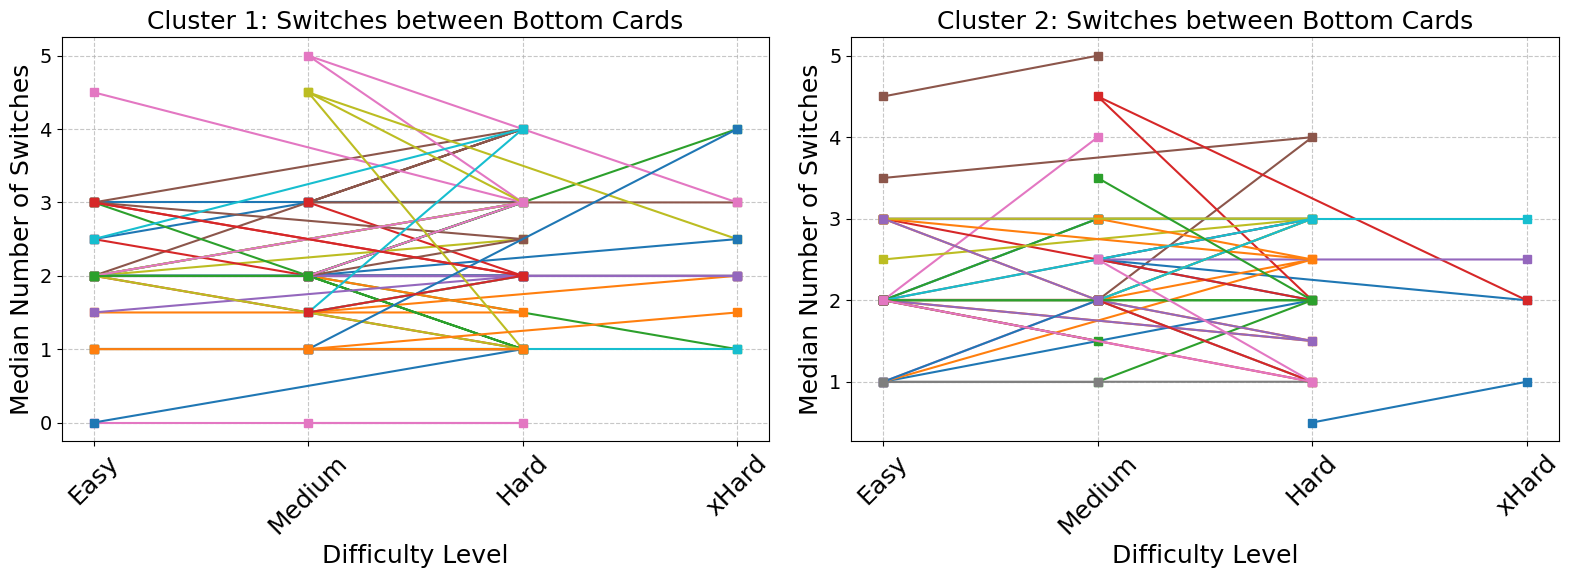

In [33]:
# Number of Switches between bottom cards (exploration) vs. difficulty level per session

#Medians
session_switches_exploration_median = exploration_data.groupby(['session', 'difficulty'])['NbSwitches'].median().unstack()

sessions_cluster_1 = ['curE002a', 'curE011a', 'curE012a', 'curE017a', 'curE018a', 'curE019a', 'curE027a', 'curE030a', 'curE032a', 'curE038a', 'curE039a', 'curE041a', 'curE045a', 'curE048a', 'curE049a', 'curE052a', 'curE063a', 'curE066a', 'curE067a', 'curE072a', 'curE075a', 'curE084a', 'curE086a', 'curE094a', 'curE106a', 'curE108a', 'curE109a', 'curE113a', 'curE114a', 'curE115a', 'curE118a', 'curE119a', 'curE121a', 'curE122a']
sessions_cluster_2 = ['curE003a', 'curE004a', 'curE008a', 'curE009a', 'curE013a', 'curE014a', 'curE020a', 'curE024a', 'curE034a', 'curE043a', 'curE046a', 'curE050a', 'curE051a', 'curE053a', 'curE054a', 'curE055a', 'curE056a', 'curE058a', 'curE062a', 'curE064a', 'curE069a', 'curE070a', 'curE071a', 'curE074a', 'curE078a', 'curE079a', 'curE080a', 'curE082a', 'curE090a', 'curE092a', 'curE098a', 'curE099a', 'curE100a', 'curE104a', 'curE107a', 'curE111a', 'curE112a', 'curE120a']

plt.figure(figsize=(16, 6))

# Plot for Cluster 1
plt.subplot(1, 2, 1)
for session in sessions_cluster_1:
    available_difficulty_levels = session_switches_exploration_median.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_switches_session = session_switches_exploration_median.loc[session][available_difficulty_levels]
        plt.plot(median_switches_session.index, median_switches_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Cluster 1: Switches between Bottom Cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Number of Switches', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
#plt.legend()

# Plot for Cluster 2
plt.subplot(1, 2, 2)
for session in sessions_cluster_2:
    available_difficulty_levels = session_switches_exploration_median.loc[session].dropna().index.tolist()
    if available_difficulty_levels:
        median_switches_session = session_switches_exploration_median.loc[session][available_difficulty_levels]
        plt.plot(median_switches_session.index, median_switches_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Cluster 2: Switches between Bottom Cards', fontsize=18)
plt.xlabel('Difficulty Level', fontsize=18)
plt.ylabel('Median Number of Switches', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=18)
#plt.legend()

plt.tight_layout()
plt.show()

# Distributions

## Total trial duration

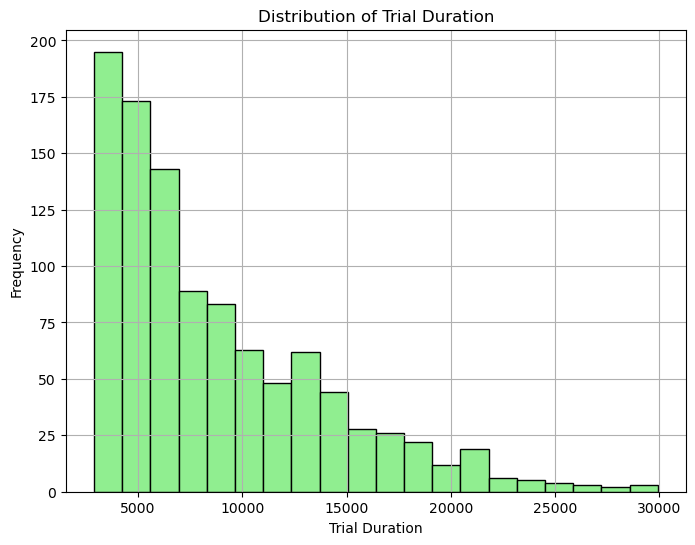

Data does not look approximately normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Best fit distribution: weibull_min


C:\Users\I587504\AppData\Local\Temp\ipykernel_41852\3688109884.py:32: RuntimeWarning: divide by zero encountered in log
  metric = -2 * np.log(p)


In [196]:
# Distribution of trial duration

trial_duration_data = trial_duration.groupby(['session', 'trialno'])['durPeriodTotal'].sum()

plt.figure(figsize=(8, 6))
plt.hist(trial_duration_data, bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Trial Duration')
plt.xlabel('Trial Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Check distribution using Kruskal-Wallis test
stat, p = kruskal(*[group.values for _, group in trial_duration_data.groupby(level=0)])

alpha = 0.05
if p > alpha:
    print("Data looks like it could be approximately normally distributed (fail to reject H0)")
else:
    print("Data does not look approximately normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']

best_fit_name = None
best_fit_params = {}
best_fit_metric = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(trial_duration_data)
    _, p = stats.kstest(trial_duration_data, distribution_name, args=params)
    metric = -2 * np.log(p) 
    if metric < best_fit_metric:
        best_fit_name = distribution_name
        best_fit_params = params
        best_fit_metric = metric

print(f"Best fit distribution: {best_fit_name}")

## Duration of exploration and decision periods

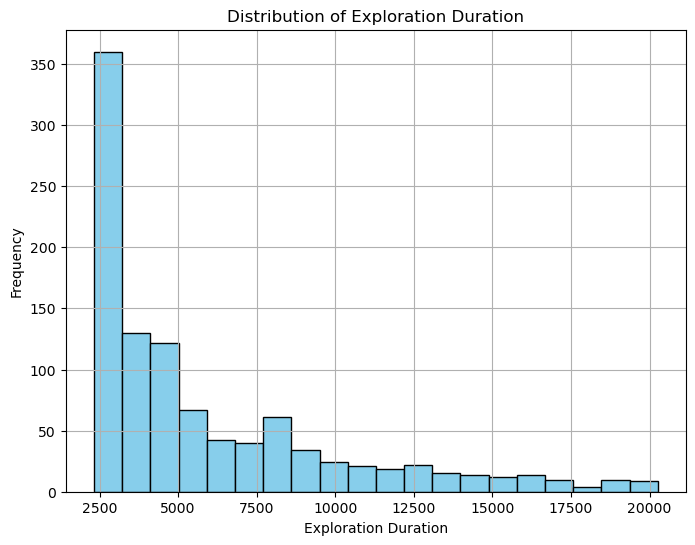

Data does not look normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Best fit distribution: beta


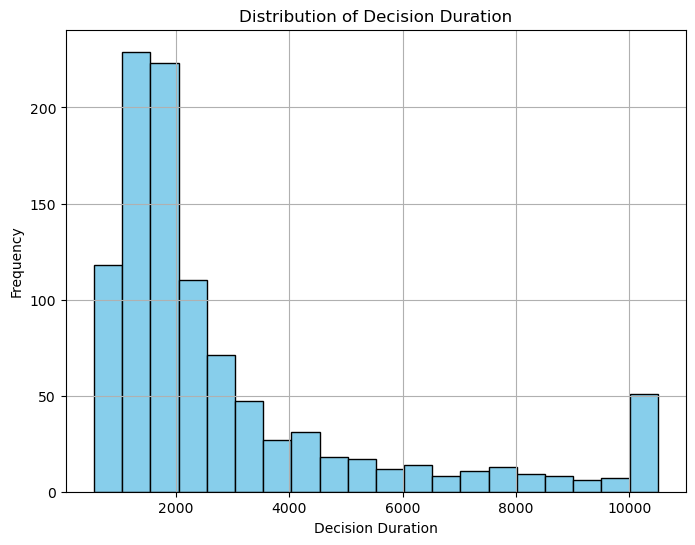

Data does not look normally distributed (reject H0)
Best fit distribution: lognorm


In [96]:
# Distribution of Exploration Duration

data_exploration = exploration_data['durPeriodTotal']

plt.figure(figsize=(8, 6))
plt.hist(data_exploration, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Exploration Duration')
plt.xlabel('Exploration Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_exploration)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_exploration)
    kstest_stat, _ = stats.kstest(data_exploration, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

# Distribution of Decision Duration

data_Decision = decision_data['durPeriodTotal']

plt.figure(figsize=(8, 6))
plt.hist(data_Decision, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Decision Duration')
plt.xlabel('Decision Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_Decision)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_Decision)
    kstest_stat, _ = stats.kstest(data_Decision, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

## Fixation Duration of Bottom Cards (Exploration Period)

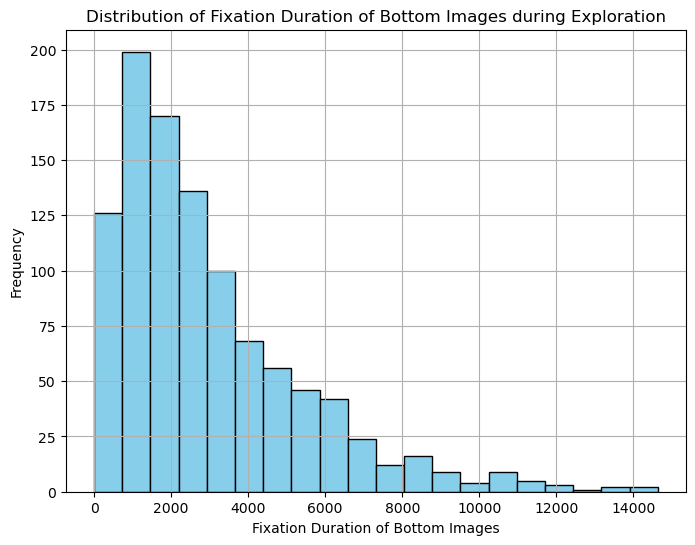

Data does not look normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best fit distribution: gamma


In [101]:
# Distribution of Fixation duration of bottom images during exploration period

data_fix_exploration = exploration_data['durfixBottom']

plt.figure(figsize=(8, 6))
plt.hist(data_fix_exploration, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Fixation Duration of Bottom Images during Exploration')
plt.xlabel('Fixation Duration of Bottom Images')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_fix_exploration)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_fix_exploration)
    kstest_stat, _ = stats.kstest(data_fix_exploration, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

## Fixation Duration of Top card (Decision Period)

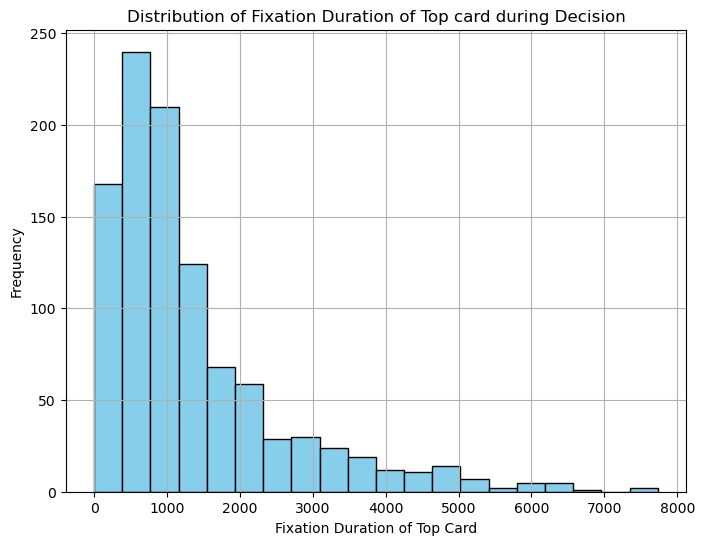

Data does not look normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best fit distribution: weibull_min


In [102]:
# Distribution of Fixation duration of top card during decision period

data_fix_decision = decision_data['FixTotDurInT']

plt.figure(figsize=(8, 6))
plt.hist(data_fix_decision, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Fixation Duration of Top card during Decision')
plt.xlabel('Fixation Duration of Top Card')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_fix_decision)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_fix_decision)
    kstest_stat, _ = stats.kstest(data_fix_decision, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

## Number of fixations of bottom cards during exploration

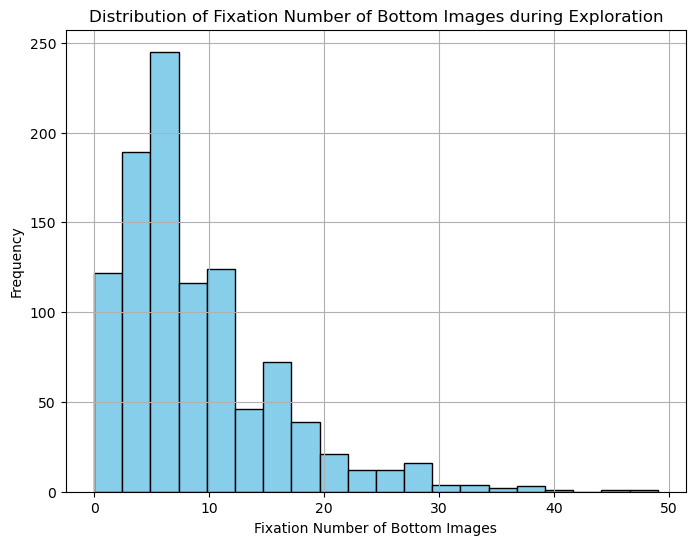

Data does not look normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best fit distribution: weibull_min


In [105]:
# Distribution of Fixation duration of bottom images during exploration period

data_fix_exploration = exploration_data['FixNbInBottom']

plt.figure(figsize=(8, 6))
plt.hist(data_fix_exploration, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Fixation Number of Bottom Images during Exploration')
plt.xlabel('Fixation Number of Bottom Images')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_fix_exploration)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_fix_exploration)
    kstest_stat, _ = stats.kstest(data_fix_exploration, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

## Number of fixations of top card during decision

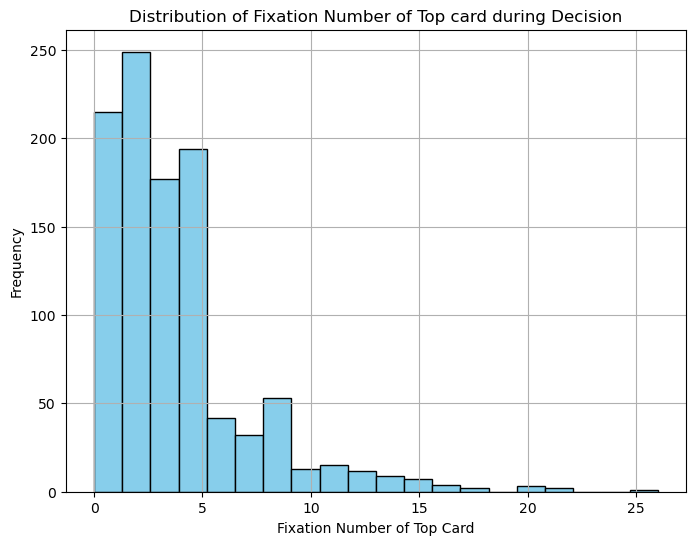

Data does not look normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best fit distribution: gamma


In [106]:
# Distribution of Fixation Number of top card during decision period

data_fix_decision = decision_data['FixNbInT']

plt.figure(figsize=(8, 6))
plt.hist(data_fix_decision, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Fixation Number of Top card during Decision')
plt.xlabel('Fixation Number of Top Card')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_fix_decision)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_fix_decision)
    kstest_stat, _ = stats.kstest(data_fix_decision, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

## Number of Switches (Exploration period)

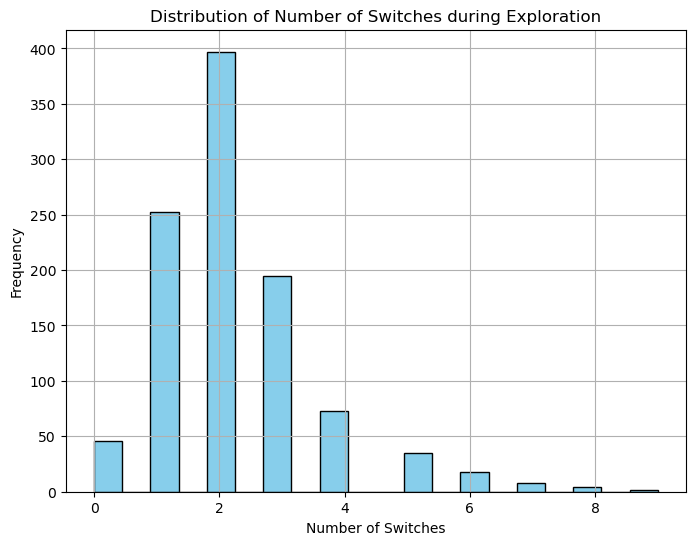

Data does not look normally distributed (reject H0)


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best fit distribution: gamma


In [108]:
# Distribution of Fixation duration of bottom images during exploration period

data_switches_exploration = exploration_data['NbSwitches']

plt.figure(figsize=(8, 6))
plt.hist(data_switches_exploration, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Switches during Exploration')
plt.xlabel('Number of Switches')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Check distribution
stat, p = shapiro(data_switches_exploration)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(data_switches_exploration)
    kstest_stat, _ = stats.kstest(data_switches_exploration, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

# Modeling 

## Dataset per trial

In [11]:
# DF DATA PER TRIAL

# Exploration period duration
exploration_df = data[data['period_in_trial'] == 'exploration']
durExplorationTotal_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()
durExplorationTotal_df.rename(columns={'durPeriodTotal': 'durExplorationPeriod'}, inplace=True)                                              

# Decision period duration
decision_df = data[data['period_in_trial'] == 'decision']
durDecisionTotal_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['durPeriodTotal'].sum().reset_index()
durDecisionTotal_df.rename(columns={'durPeriodTotal': 'durDecisionPeriod'}, inplace=True)

# Trial duration
trialduration_df = data.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

# Accuracy
decision_df = data[data['period_in_trial'] == 'decision']
accuracy_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['accuracy'].sum().reset_index()

# Side Chosen
decision_df = data[data['period_in_trial'] == 'decision']
sideChosen_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['sideChosen'].sum().reset_index()

#Number of switches during exploration period
exploration_df = data[data['period_in_trial'] == 'exploration']
SwitchesExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesExploration_df.rename(columns={'NbSwitches': 'SwitchesExplorationPeriod'}, inplace=True)   

#Number of switches during decision period
decision_df = data[data['period_in_trial'] == 'decision']
SwitchesDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesDecision_df.rename(columns={'NbSwitches': 'SwitchesDecisionPeriod'}, inplace=True)   

#Number of switches in total
SwitchesTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()

#Fixation number during exploration period
exploration_df = data[data['period_in_trial'] == 'exploration']
FixNbExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbExploration_df.rename(columns={'FixNb': 'FixNbExplorationPeriod'}, inplace=True)   

#Fixation number during decision period
decision_df = data[data['period_in_trial'] == 'decision']
FixNbDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbDecision_df.rename(columns={'FixNb': 'FixNbDecisionPeriod'}, inplace=True)   

#Fixation number in total
FixNbTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()

#Fixation number in top card during decision period
decision_df = data[data['period_in_trial'] == 'decision']
FixNbTD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTD_df.rename(columns={'FixNbInT': 'FixNbInTDecision'}, inplace=True)   

#Fixation number in top card during exploration period
exploration_df = data[data['period_in_trial'] == 'exploration']
FixNbTE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTE_df.rename(columns={'FixNbInT': 'FixNbInTExploration'}, inplace=True) 

#Fixation number in Bottom cards during exploration period
exploration_df = data[data['period_in_trial'] == 'exploration']
FixNbBottom_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()
FixNbBottom_df.rename(columns={'FixNbInBottom': 'FixNbInBottomExploration'}, inplace=True)

#Fixation number in Bottom during both periods
FixNbBottomTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()

#Fixation number in Top during both periods
FixNbInTTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()

# Look total duration in top card during decision period
decision_df = data[data['period_in_trial'] == 'decision']
LookDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTDecision_df.rename(columns={'LookTotDurInT': 'LookDurInTDecision'}, inplace=True)   

# Look total duration in top card during exploration period
exploration_df = data[data['period_in_trial'] == 'decision']
LookDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTExploration_df.rename(columns={'LookTotDurInT': 'LookDurInTExploration'}, inplace=True)  

# Look total duration in bottom cards during exploration period
exploration_df = data[data['period_in_trial'] == 'exploration']
LookDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBE_df.rename(columns={'durLookBottom': 'durLookBottomExploration'}, inplace=True)

# Look total duration in bottom cards during decision period
decision_df = data[data['period_in_trial'] == 'decision']
LookDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBD_df.rename(columns={'durLookBottom': 'durLookBottomDecision'}, inplace=True)

# Look total duration in Bottom cards during both periods
LookDurBottomTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()

# Look total duration in Top Card during both periods
LookDurTopTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()

# Fixation duration of top card during decision period
decision_df = data[data['period_in_trial'] == 'decision']
FixDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTDecision_df.rename(columns={'FixTotDurInT': 'FixDurInTDecision'}, inplace=True)   

# Fixation duration of top card during exploration period
exploration_df = data[data['period_in_trial'] == 'decision']
FixDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTExploration_df.rename(columns={'FixTotDurInT': 'FixDurInTExploration'}, inplace=True)  

# Fixation duration of bottom cards during exploration period
exploration_df = data[data['period_in_trial'] == 'exploration']
FixDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBE_df.rename(columns={'durfixBottom': 'durfixBottomExploration'}, inplace=True)

# Fixation duration of bottom cards during decision period
decision_df = data[data['period_in_trial'] == 'decision']
FixDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBD_df.rename(columns={'durfixBottom': 'durfixBottomDecision'}, inplace=True)

# Fixation duration of Bottom cards during both periods
FixDurBottomTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()

# Fixation duration of Top card during both periods
FixDurTopTotal_df = data.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()

merged_filtered_data = accuracy_df.merge(sideChosen_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(trialduration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durExplorationTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durDecisionTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(SwitchesTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(FixNbExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottom_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbInTTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(LookDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')


merged_filtered_data = merged_filtered_data.merge(FixDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.dropna() 
merged_filtered_data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0     curE002a        8       Easy       0.0       left           12194   
1     curE002a        9       Easy       1.0       left            4680   
2     curE002a       10       Easy       1.0      right           12826   
3     curE002a       11     Medium       1.0      right            3910   
4     curE002a       12     Medium       0.0       left           15256   
...        ...      ...        ...       ...        ...             ...   
1270  curE122a       27     Medium       1.0       left           14690   
1271  curE122a       28     Medium       1.0      right           14362   
1272  curE122a       35       Hard       1.0       left           18326   
1273  curE122a       38       Hard       1.0       left            2996   
1275  curE122a       48     Medium       0.0       left            3300   

      durExplorationPeriod  durDecisionPeriod  NbSwitches  \
0                  11270.0              924.0           6   
1                   2498.0             2182.0           2   
2                   9912.0             2914.0           4   
3                   2328.0             1582.0           3   
4                  14272.0              984.0           6   
...                    ...                ...         ...   
1270               13092.0             1598.0           2   
1271               13796.0              566.0           4   
1272               16894.0             1432.0           5   
1273                2414.0              582.0           3   
1275                2332.0              968.0           2   

      SwitchesExplorationPeriod  ...  durLookBottomExploration  \
0                           6.0  ...                    5480.0   
1                           2.0  ...                    1670.0   
2                           3.0  ...                    2658.0   
3                           2.0  ...                     994.0   
4                           5.0  ...                    7554.0   
...                         ...  ...                       ...   
1270                        2.0  ...                    9398.0   
1271                        3.0  ...                    6946.0   
1272                        5.0  ...                   11690.0   
1273                        2.0  ...                    1586.0   
1275                        1.0  ...                     596.0   

      durLookBottomDecision  durLookBottom  LookTotDurInT  FixDurInTDecision  \
0                     536.0           6016           1208              298.0   
1                     530.0           2200           2176             1466.0   
2                     106.0           2764           2020              798.0   
3                     470.0           1464           1780              646.0   
4                     476.0           8030           1296              406.0   
...                     ...            ...            ...                ...   
1270                  394.0           9792           1484              876.0   
1271                  474.0           7420            288                0.0   
1272                    0.0          11690            118                0.0   
1273                  488.0           2074            502                0.0   
1275                  468.0           1064           2104              390.0   

      FixDurInTExploration  durfixBottomExploration  durfixBottomDecision  \
0                    298.0                   4952.0                 536.0   
1                   1466.0                   1468.0                 470.0   
2                    798.0                   2546.0                 364.0   
3                    646.0                    960.0                 420.0   
4                    406.0                   7048.0                 476.0   
...                    ...                      ...                   ...   
1270                 876.0                   8682.0                 308.0   
127

## Total Trial Duration vs. Difficulty Level
Check if the difficulty level predicts total trial duration

In [13]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: Weibull 
# Only linear

merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durPeriodTotal'] = np.log(merged_filtered_data['durPeriodTotal'] + 0.001) # Transform trial duration to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durPeriodTotal'] = scaler.fit_transform(merged_filtered_data[['transformed_durPeriodTotal']])

formula = 'scaled_transformed_durPeriodTotal ~ difficulty + (1 + difficulty | session)' #random slope and random intercept for difficulty within sessions

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durPeriodTotal']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durPeriodTotal
No. Observations: 1194    Method:             REML                             
No. Groups:       72      Scale:              0.0458                           
Min. group size:  5       Log-Likelihood:     79.6135                          
Max. group size:  40      Converged:          Yes                              
Mean group size:  16.6                                                         
----------------------------------------------------------------------------------
                         Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------------------
Intercept                 0.448       0.028    15.999    0.000     0.393     0.503
difficulty                0.003       0.007     0.458    0.647    -0.010     0.016
difficulty | session     -0.000       0.001   

In [35]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: Weibull 
# Non- linearity: quadratic function

merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durPeriodTotal'] = np.log(merged_filtered_data['durPeriodTotal'] + 0.001) # Transform trial duration to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durPeriodTotal'] = scaler.fit_transform(merged_filtered_data[['transformed_durPeriodTotal']])

formula = 'scaled_transformed_durPeriodTotal ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' # considering non-linearity #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durPeriodTotal']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durPeriodTotal
No. Observations: 1194    Method:             REML                             
No. Groups:       72      Scale:              0.0457                           
Min. group size:  5       Log-Likelihood:     78.4017                          
Max. group size:  40      Converged:          Yes                              
Mean group size:  16.6                                                         
---------------------------------------------------------------------------------
                             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                     0.444      0.028   15.974   0.000    0.390    0.499
difficulty                    0.049      0.021    2.347   0.019    0.008    0.089
np.power(difficulty, 2)      -0.019      0.008   -2

In [28]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: Weibull 
# Non- linearity: square root transformation

merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durPeriodTotal'] = np.log(merged_filtered_data['durPeriodTotal'] + 0.001) # Transform trial duration to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durPeriodTotal'] = scaler.fit_transform(merged_filtered_data[['transformed_durPeriodTotal']])

formula = 'scaled_transformed_durPeriodTotal ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' # square root transformation for difficulty (non-linearity) #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durPeriodTotal']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durPeriodTotal
No. Observations: 1194    Method:             REML                             
No. Groups:       72      Scale:              0.0456                           
Min. group size:  5       Log-Likelihood:     81.6943                          
Max. group size:  40      Converged:          Yes                              
Mean group size:  16.6                                                         
---------------------------------------------------------------------------------
                             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                     0.441      0.028   15.817   0.000    0.387    0.496
difficulty                   -0.079      0.029   -2.751   0.006   -0.135   -0.023
np.power(difficulty, 0.5)     0.128      0.044    2

In [20]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [79.6135, 78.4017 , 81.6943] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -153.227
Model 2 AIC: -148.8034
Model 3 AIC: -155.3886

The best model is Model 3 with AIC: -155.3886


## Exploration Period Duration vs. Difficulty Level

In [14]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durExplorationPeriod
# Distribution: beta
# Linear

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_durExplorationPeriod'] = scaler.fit_transform(merged_filtered_data[['durExplorationPeriod']]) #transforming durExplorationPeriod to fit into (0, 1) range

formula = 'scaled_durExplorationPeriod ~ difficulty + (1 + difficulty | session)' # random intercept and slope for difficulty

mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=merged_filtered_data, 
    groups=merged_filtered_data['session'],  
)
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_durExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durExplorationPeriod
No. Observations: 1194    Method:             REML                       
No. Groups:       72      Scale:              0.0498                     
Min. group size:  5       Log-Likelihood:     39.5906                    
Max. group size:  40      Converged:          Yes                        
Mean group size:  16.6                                                   
---------------------------------------------------------------------------
                       Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------
Intercept               0.229      0.026    8.932   0.000    0.179    0.279
difficulty              0.000      0.007    0.071   0.943   -0.013    0.014
difficulty | session   -0.000      0.001   -0.404   0.686   -0.001    0.001
Group Var               0.008      0.009    

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [16]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durExplorationPeriod
# Distribution: beta
#Non linear: quadratic term

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_durExplorationPeriod'] = scaler.fit_transform(merged_filtered_data[['durExplorationPeriod']]) #transforming durExplorationPeriod to fit into (0, 1) range

formula = 'scaled_durExplorationPeriod ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' #accounting for non-linear trend here # random intercept and slope for difficulty

mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=merged_filtered_data, 
    groups=merged_filtered_data['session'],  
)
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_durExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durExplorationPeriod
No. Observations: 1194    Method:             REML                       
No. Groups:       72      Scale:              0.0497                     
Min. group size:  5       Log-Likelihood:     38.2194                    
Max. group size:  40      Converged:          Yes                        
Mean group size:  16.6                                                   
--------------------------------------------------------------------------
                           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.225     0.025   8.843  0.000   0.175   0.275
difficulty                  0.046     0.021   2.143  0.032   0.004   0.088
np.power(difficulty, 2)    -0.019     0.008  -2.236  0.025  -0.035  -0.002
difficulty | session       -0.000     0.001  -0.57

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durExplorationPeriod
# Distribution: beta
#Non linear: square root transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_durExplorationPeriod'] = scaler.fit_transform(merged_filtered_data[['durExplorationPeriod']]) #transforming durExplorationPeriod to fit into (0, 1) range

formula = 'scaled_durExplorationPeriod ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' #accounting for non-linear trend here # random intercept and slope 

mixed_model = sm.MixedLM.from_formula(
    formula, 
    data=merged_filtered_data, 
    groups=merged_filtered_data['session'],  
)
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_durExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_durExplorationPeriod
No. Observations: 1194    Method:             REML                       
No. Groups:       72      Scale:              0.0496                     
Min. group size:  5       Log-Likelihood:     41.0109                    
Max. group size:  40      Converged:          Yes                        
Mean group size:  16.6                                                   
--------------------------------------------------------------------------
                           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.223     0.026   8.691  0.000   0.172   0.273
difficulty                 -0.077     0.030  -2.598  0.009  -0.136  -0.019
np.power(difficulty, 0.5)   0.121     0.045   2.686  0.007   0.033   0.210
difficulty | session       -0.000     0.001  -0.59

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [39.5906, 38.2194, 41.0109] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -73.1812
Model 2 AIC: -68.4388
Model 3 AIC: -74.0218

The best model is Model 3 with AIC: -74.0218


## Decision Period Duration vs. Difficulty Level

In [19]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durDecisionPeriod
# Distribution: Log-normal
# non linear: square root transformation

merged_filtered_data['log_durDecisionPeriod'] = np.log(merged_filtered_data['durDecisionPeriod'])
merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = StandardScaler() 
merged_filtered_data[['log_durDecisionPeriod']] = scaler.fit_transform(merged_filtered_data[['log_durDecisionPeriod']]) # Decision period duration follows a log-normal distribution

formula = 'log_durDecisionPeriod ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' #Random intercept and random slope for difficulty #Also accounting for non-linear trend

mixed_model = smf.mixedlm(formula, merged_filtered_data, groups=merged_filtered_data['session'])
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['log_durDecisionPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

               Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: log_durDecisionPeriod
No. Observations:  1194    Method:             REML                 
No. Groups:        72      Scale:              0.8425               
Min. group size:   5       Log-Likelihood:     -1648.8066           
Max. group size:   40      Converged:          Yes                  
Mean group size:   16.6                                             
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.145    0.112  1.297 0.194 -0.074  0.364
difficulty                -0.191    0.123 -1.552 0.121 -0.433  0.050
np.power(difficulty, 0.5)  0.286    0.187  1.534 0.125 -0.080  0.652
difficulty | session      -0.003    0.003 -1.284 0.199 -0.009  0.002
Group Var                  0.156    0.040         

In [22]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durDecisionPeriod
# Distribution: Log-normal
# non linear: quadratic transformation

merged_filtered_data['log_durDecisionPeriod'] = np.log(merged_filtered_data['durDecisionPeriod'])
merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = StandardScaler() 
merged_filtered_data[['log_durDecisionPeriod']] = scaler.fit_transform(merged_filtered_data[['log_durDecisionPeriod']]) # Decision period duration follows a log-normal distribution

formula = 'log_durDecisionPeriod ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' #Random intercept and random slope for difficulty #Also accounting for non-linear trend

mixed_model = smf.mixedlm(formula, merged_filtered_data, groups=merged_filtered_data['session'])
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['log_durDecisionPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_durDecisionPeriod
No. Observations: 1194    Method:             REML                 
No. Groups:       72      Scale:              0.8432               
Min. group size:  5       Log-Likelihood:     -1651.0713           
Max. group size:  40      Converged:          Yes                  
Mean group size:  16.6                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.152    0.112  1.363 0.173 -0.067  0.371
difficulty                0.085    0.089  0.957 0.338 -0.089  0.259
np.power(difficulty, 2)  -0.038    0.034 -1.097 0.273 -0.105  0.030
difficulty | session     -0.003    0.003 -1.255 0.209 -0.009  0.002
Group Var                 0.157    0.040                       

In [23]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durDecisionPeriod
# Distribution: Log-normal
#linear

merged_filtered_data['log_durDecisionPeriod'] = np.log(merged_filtered_data['durDecisionPeriod'])
merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = StandardScaler() 
merged_filtered_data[['log_durDecisionPeriod']] = scaler.fit_transform(merged_filtered_data[['log_durDecisionPeriod']]) # Decision period duration follows a log-normal distribution

formula = 'log_durDecisionPeriod ~ difficulty + (1 + difficulty | session)' #Random intercept and random slope for difficulty

mixed_model = smf.mixedlm(formula, merged_filtered_data, groups=merged_filtered_data['session'])
result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['log_durDecisionPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_durDecisionPeriod
No. Observations: 1194    Method:             REML                 
No. Groups:       72      Scale:              0.8430               
Min. group size:  5       Log-Likelihood:     -1649.2228           
Max. group size:  40      Converged:          Yes                  
Mean group size:  16.6                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.160    0.112  1.432 0.152 -0.059  0.380
difficulty               -0.007    0.028 -0.259 0.796 -0.063  0.048
difficulty | session     -0.003    0.003 -1.178 0.239 -0.008  0.002
Group Var                 0.158    0.041                           

Mean Absolute Error (MAE): 0.8069742404936858
Mean Squared Err

In [26]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [4, 4, 3] 
model_log_likelihood = [-1648.8066, -1651.0713, -1649.2228 ] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: 3305.6132
Model 2 AIC: 3310.1426
Model 3 AIC: 3306.4456

The best model is Model 1 with AIC: 3305.6132


## Fixation Duration of bottom cards (exploration period) vs. Difficulty Level

In [11]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durfixBottomExploration
# Distribution: gamma
# Linear

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durfixBottomExploration'] = np.log(merged_filtered_data['durfixBottomExploration'] + 0.001) # Transform durfixBottomExploration to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durfixBottomExploration'] = scaler.fit_transform(merged_filtered_data[['transformed_durfixBottomExploration']])

formula = 'scaled_transformed_durfixBottomExploration ~ difficulty + (1 + difficulty | session)'#random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durfixBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durfixBottomExploration
No. Observations: 1194    Method:             REML                                      
No. Groups:       72      Scale:              0.0213                                    
Min. group size:  5       Log-Likelihood:     519.5502                                  
Max. group size:  40      Converged:          Yes                                       
Mean group size:  16.6                                                                  
---------------------------------------------------------------------------------------------
                          Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  0.860         0.024      35.695      0.000       0.813       0.907
difficulty                -

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [22]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durfixBottomExploration
# Distribution: gamma
# Non-linearity: quadratic transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durfixBottomExploration'] = np.log(merged_filtered_data['durfixBottomExploration'] + 0.001) # Transform durfixBottomExploration to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durfixBottomExploration'] = scaler.fit_transform(merged_filtered_data[['transformed_durfixBottomExploration']])

formula = 'scaled_transformed_durfixBottomExploration ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' # Quadratic term for difficulty (non-linearity) #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durfixBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durfixBottomExploration
No. Observations: 1248    Method:             REML                                      
No. Groups:       85      Scale:              0.0216                                    
Min. group size:  1       Log-Likelihood:     530.2902                                  
Max. group size:  40      Converged:          Yes                                       
Mean group size:  14.7                                                                  
--------------------------------------------------------------------------------------------
                              Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
--------------------------------------------------------------------------------------------
Intercept                      0.855        0.022     38.801     0.000      0.812      0.898
difficulty                    -

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [23]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durfixBottomExploration
# Distribution: gamma
# Non-linearity: square root transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_durfixBottomExploration'] = np.log(merged_filtered_data['durfixBottomExploration'] + 0.001) # Transform durfixBottomExploration to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_durfixBottomExploration'] = scaler.fit_transform(merged_filtered_data[['transformed_durfixBottomExploration']])

formula = 'scaled_transformed_durfixBottomExploration ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' # Square root transformation for difficulty (non-linearity) #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_durfixBottomExploration']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_durfixBottomExploration
No. Observations: 1248    Method:             REML                                      
No. Groups:       85      Scale:              0.0216                                    
Min. group size:  1       Log-Likelihood:     531.9547                                  
Max. group size:  40      Converged:          Yes                                       
Mean group size:  14.7                                                                  
--------------------------------------------------------------------------------------------
                              Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
--------------------------------------------------------------------------------------------
Intercept                      0.855        0.022     38.776     0.000      0.812      0.898
difficulty                    -

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [519.5502, 530.2902, 531.9547] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -1033.1004
Model 2 AIC: -1052.5804
Model 3 AIC: -1055.9094

The best model is Model 3 with AIC: -1055.9094


## Fixation duration of Top Card (Decision Period) vs. Difficulty Level

In [59]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixDurInTDecision
# Distribution: Weibull 
# Linear

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixDurInTDecision'] = np.log(merged_filtered_data['FixDurInTDecision'] + 0.001) # Transform FixDurInTDecision to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixDurInTDecision'] = scaler.fit_transform(merged_filtered_data[['transformed_FixDurInTDecision']])

formula = 'scaled_transformed_FixDurInTDecision ~ difficulty + (1 + difficulty | session)' #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixDurInTDecision']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixDurInTDecision
No. Observations: 1194    Method:             REML                                
No. Groups:       72      Scale:              0.0217                              
Min. group size:  5       Log-Likelihood:     533.5191                            
Max. group size:  40      Converged:          Yes                                 
Mean group size:  16.6                                                            
-------------------------------------------------------------------------------------
                            Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-------------------------------------------------------------------------------------
Intercept                    0.194       0.017    11.197    0.000     0.160     0.229
difficulty                  -0.006       0.005    -1.236    0.216    -0.014     0.003
difficulty |

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [35]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixDurInTDecision
# Distribution: Weibull 
# Non-linearity: square root transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixDurInTDecision'] = np.log(merged_filtered_data['FixDurInTDecision'] + 0.001) # Transform FixDurInTDecision to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixDurInTDecision'] = scaler.fit_transform(merged_filtered_data[['transformed_FixDurInTDecision']])

formula = 'scaled_transformed_FixDurInTDecision ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' # Square root trasnformation for difficulty (non-linearity) #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixDurInTDecision']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixDurInTDecision
No. Observations: 1194    Method:             REML                                
No. Groups:       72      Scale:              0.0498                              
Min. group size:  5       Log-Likelihood:     65.8332                             
Max. group size:  40      Converged:          Yes                                 
Mean group size:  16.6                                                            
------------------------------------------------------------------------------------
                                Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------------------
Intercept                        0.854      0.018   48.312   0.000    0.819    0.888
difficulty                       0.002      0.029    0.084   0.933   -0.055    0.060
np.power(difficul

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [34]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixDurInTDecision
# Distribution: Weibull 
# Non-linearity: quadratic transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixDurInTDecision'] = np.log(merged_filtered_data['FixDurInTDecision'] + 0.001) # Transform FixDurInTDecision to fit a Weibull distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixDurInTDecision'] = scaler.fit_transform(merged_filtered_data[['transformed_FixDurInTDecision']])

formula = 'scaled_transformed_FixDurInTDecision ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' # Quadratic trasnformation for difficulty (non-linearity) #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixDurInTDecision']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixDurInTDecision
No. Observations: 1194    Method:             REML                                
No. Groups:       72      Scale:              0.0498                              
Min. group size:  5       Log-Likelihood:     64.1134                             
Max. group size:  40      Converged:          Yes                                 
Mean group size:  16.6                                                            
-------------------------------------------------------------------------------------
                            Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-------------------------------------------------------------------------------------
Intercept                    0.853       0.018    48.498    0.000     0.818     0.887
difficulty                  -0.003       0.021    -0.124    0.901    -0.044     0.038
np.power(dif

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [35]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [67.9958, 65.8332, 64.1134] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -129.9916
Model 2 AIC: -123.66640000000001
Model 3 AIC: -120.2268

The best model is Model 1 with AIC: -129.9916


## Number of Fixations for bottom cards during exploration period vs. Difficulty Level 

In [66]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: number of fixations for bottom cards during exploration period
# Distribution: Weibull
# Linear

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_FixNbBE'] = scaler.fit_transform(merged_filtered_data[['FixNb']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_FixNbBE ~ difficulty + (1 + difficulty | session)' # random intercept and slope for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_FixNbBE']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  scaled_FixNbBE
No. Observations:  1194     Method:              REML          
No. Groups:        72       Scale:               0.0166        
Min. group size:   5        Log-Likelihood:      683.6559      
Max. group size:   40       Converged:           Yes           
Mean group size:   16.6                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.273    0.017 16.178 0.000  0.240  0.306
log_difficulty        0.001    0.001  0.467 0.641 -0.002  0.003
difficulty | session -0.000    0.000 -1.046 0.295 -0.001  0.000
Group Var             0.004    0.007                           

Mean Absolute Error (MAE): 0.10900066814618704
Mean Squared Error (MSE): 0.020202368422519115


C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [37]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: number of fixations
# Distribution: Weibull
#Non-linearity: quadratic term

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_FixNbBE'] = scaler.fit_transform(merged_filtered_data[['FixNb']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_FixNbBE ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' #accounting for non-linear trend here # random intercept and slope for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_FixNbBE']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   scaled_FixNb
No. Observations:     1194      Method:               REML        
No. Groups:           72        Scale:                0.0166      
Min. group size:      5         Log-Likelihood:       682.4384    
Max. group size:      40        Converged:            Yes         
Mean group size:      16.6                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.271    0.017 16.294 0.000  0.239  0.304
difficulty               0.021    0.012  1.665 0.096 -0.004  0.045
np.power(difficulty, 2) -0.009    0.005 -1.943 0.052 -0.019  0.000
difficulty | session    -0.000    0.000 -1.154 0.249 -0.001  0.000
Group Var                0.004    0.007                           

Mean Abso

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [38]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: number of fixations
# Distribution: Weibull
# non-linearity: square root transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_FixNbBE'] = scaler.fit_transform(merged_filtered_data[['FixNb']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_FixNbBE ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' #accounting for non-linear trend here # random intercept and slope

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_FixNbBE']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    scaled_FixNb
No. Observations:     1194       Method:                REML        
No. Groups:           72         Scale:                 0.0166      
Min. group size:      5          Log-Likelihood:        684.7873    
Max. group size:      40         Converged:             Yes         
Mean group size:      16.6                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.270    0.017 16.174 0.000  0.237  0.303
difficulty                -0.040    0.017 -2.325 0.020 -0.074 -0.006
np.power(difficulty, 0.5)  0.059    0.026  2.258 0.024  0.008  0.111
difficulty | session      -0.000    0.000 -1.168 0.243 -0.001  0.000
Group Var                  0.004    0.007         

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [683.6559, 682.4384, 684.7873] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -1361.3118
Model 2 AIC: -1356.8768
Model 3 AIC: -1361.5746

The best model is Model 3 with AIC: -1361.5746


## Number of fixations of top card during decision vs. Difficulty Level

In [44]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbTD
# Distribution: gamma
# Linear

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixNbTD'] = np.log(merged_filtered_data['FixNbInTDecision'] + 0.001) # Transform FixNbTD to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixNbTD'] = scaler.fit_transform(merged_filtered_data[['transformed_FixNbTD']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_FixNbTD ~ difficulty + ( 1 + difficulty | session)' #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixNbTD']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbTD
No. Observations: 1194    Method:             REML                      
No. Groups:       72      Scale:              0.0445                    
Min. group size:  5       Log-Likelihood:     135.7645                  
Max. group size:  40      Converged:          Yes                       
Mean group size:  16.6                                                  
-------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  0.775     0.016  47.411  0.000   0.743   0.807
difficulty                -0.005     0.006  -0.782  0.434  -0.017   0.007
difficulty | session      -0.001     0.000  -2.796  0.005  -0.002  -0.000
Group Var                  0.001     0.003                     

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [45]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbTD
# Distribution: gamma
# quadratic transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixNbTD'] = np.log(merged_filtered_data['FixNbInTDecision'] + 0.001) # Transform FixNbTD to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixNbTD'] = scaler.fit_transform(merged_filtered_data[['transformed_FixNbTD']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_FixNbTD ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' # Accounting for non-linearity #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixNbTD']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbTD
No. Observations: 1194    Method:             REML                      
No. Groups:       72      Scale:              0.0445                    
Min. group size:  5       Log-Likelihood:     131.8468                  
Max. group size:  40      Converged:          Yes                       
Mean group size:  16.6                                                  
-------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  0.775     0.016  47.204  0.000   0.743   0.807
difficulty                -0.000     0.020  -0.000  1.000  -0.039   0.039
np.power(difficulty, 2)   -0.002     0.008  -0.256  0.798  -0.017   0.013
difficulty | session      -0.001     0.000  -2.809  0.005  -0.0

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [46]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: FixNbTD
# Distribution: gamma
# Non- linearity: square root transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_FixNbTD'] = np.log(merged_filtered_data['FixNbInTDecision'] + 0.001) # Transform FixNbTD to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_FixNbTD'] = scaler.fit_transform(merged_filtered_data[['transformed_FixNbTD']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_FixNbTD ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' # Accounting for non-linearity #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_FixNbTD']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_FixNbTD
No. Observations: 1194    Method:             REML                      
No. Groups:       72      Scale:              0.0445                    
Min. group size:  5       Log-Likelihood:     133.5182                  
Max. group size:  40      Converged:          Yes                       
Mean group size:  16.6                                                  
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.776    0.017 46.997 0.000  0.743  0.808
difficulty                    -0.001    0.028 -0.019 0.985 -0.055  0.054
np.power(difficulty, 0.5)     -0.007    0.042 -0.159 0.874 -0.088  0.075
difficulty | session          -0.001    0.000 -2.763 0.006 -0.002 -0.

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [47]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [135.7645, 131.8468 , 133.5182] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -265.529
Model 2 AIC: -255.6936
Model 3 AIC: -259.0364

The best model is Model 1 with AIC: -265.529


## Number of Switches during Exploration Period vs. Difficulty Level 

In [48]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: SwitchesExplorationPeriod
# Distribution: gamma
# Linear

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_SwitchesExplorationPeriod'] = np.log(merged_filtered_data['SwitchesExplorationPeriod'] + 0.001) # Transform SwitchesExplorationPeriod to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod'] = scaler.fit_transform(merged_filtered_data[['transformed_SwitchesExplorationPeriod']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_SwitchesExplorationPeriod ~ difficulty + (1 + difficulty | session)' #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_SwitchesExplorationPeriod
No. Observations: 1194    Method:             REML                                        
No. Groups:       72      Scale:              0.0203                                      
Min. group size:  5       Log-Likelihood:     541.2267                                    
Max. group size:  40      Converged:          Yes                                         
Mean group size:  16.6                                                                    
-----------------------------------------------------------------------------------------------
                            Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    0.796         0.026      31.065      0.000       0.746       0.846
diffic

In [49]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: SwitchesExplorationPeriod
# Distribution: gamma
#Non- linearity: quadratic transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_SwitchesExplorationPeriod'] = np.log(merged_filtered_data['SwitchesExplorationPeriod'] + 0.001) # Transform SwitchesExplorationPeriod to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod'] = scaler.fit_transform(merged_filtered_data[['transformed_SwitchesExplorationPeriod']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_SwitchesExplorationPeriod ~ difficulty + np.power(difficulty, 2) + (1 + difficulty | session)' # Accounting for non linear trend #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_SwitchesExplorationPeriod
No. Observations: 1194    Method:             REML                                        
No. Groups:       72      Scale:              0.0203                                      
Min. group size:  5       Log-Likelihood:     537.1951                                    
Max. group size:  40      Converged:          Yes                                         
Mean group size:  16.6                                                                    
----------------------------------------------------------------------------------------------
                                Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
----------------------------------------------------------------------------------------------
Intercept                        0.797        0.026     31.093     0.000      0.747      0.847
difficulty

In [50]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: SwitchesExplorationPeriod
# Distribution: gamma
#Non-linearity: square root transformation

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes

merged_filtered_data['transformed_SwitchesExplorationPeriod'] = np.log(merged_filtered_data['SwitchesExplorationPeriod'] + 0.001) # Transform SwitchesExplorationPeriod to fit a Gamma distribution

scaler = MinMaxScaler(feature_range=(0, 1))
merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod'] = scaler.fit_transform(merged_filtered_data[['transformed_SwitchesExplorationPeriod']]) #transforming FixNb to fit into (0, 1) range (gamma distribution is followed)

formula = 'scaled_transformed_SwitchesExplorationPeriod ~ difficulty + np.power(difficulty, 0.5) + (1 + difficulty | session)' # Accounting for non linear trend #random slope and random intercept for difficulty

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['scaled_transformed_SwitchesExplorationPeriod']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_transformed_SwitchesExplorationPeriod
No. Observations: 1194    Method:             REML                                        
No. Groups:       72      Scale:              0.0203                                      
Min. group size:  5       Log-Likelihood:     539.0100                                    
Max. group size:  40      Converged:          Yes                                         
Mean group size:  16.6                                                                    
----------------------------------------------------------------------------------------------
                                Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
----------------------------------------------------------------------------------------------
Intercept                        0.797        0.026     31.093     0.000      0.747      0.848
difficulty

In [51]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [3, 4, 4] 
model_log_likelihood = [541.2267, 537.1951, 539.0100] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

for i, aic in enumerate(model_aic):
    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")

Model 1 AIC: -1076.4534
Model 2 AIC: -1066.3902
Model 3 AIC: -1070.02

The best model is Model 1 with AIC: -1076.4534


## Accuracy vs. Difficulty Level 
Check if the difficulty level predicts accuracy

In [29]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: accuracy
# Distribution: Binomial

merged_filtered_data['difficulty'] = merged_filtered_data['difficulty'].astype('category').cat.codes
merged_filtered_data['session'] = merged_filtered_data['session'].astype('category').cat.codes
merged_filtered_data['accuracy'] = merged_filtered_data['accuracy'].astype('category').cat.codes

merged_filtered_data['accuracy_encoded'] = np.where(merged_filtered_data['accuracy'] == 1, 1, 0)

merged_filtered_data['logit_accuracy'] = np.log(merged_filtered_data['accuracy_encoded'] / (1 - merged_filtered_data['accuracy_encoded'])) # Logit transformation for binomial nature of accuracy

formula = 'logit_accuracy ~ np.power(difficulty, 2) + (1 + difficulty| session)' #accounting for random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=merged_filtered_data, groups=merged_filtered_data['session'])

result = mixed_model.fit()

predicted_values = result.predict()

observed_values = merged_filtered_data['logit_accuracy']

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observed_values, predicted_values)

# Mean Squared Error (MSE)
mse = mean_squared_error(observed_values, predicted_values)

print(result.summary())
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    accuracy 
No. Observations:      1194       Method:                REML     
No. Groups:            72         Scale:                 0.2486   
Min. group size:       5          Log-Likelihood:        -878.4442
Max. group size:       40         Converged:             Yes      
Mean group size:       16.6                                       
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.544    0.033 16.663 0.000  0.480  0.608
np.power(difficulty, 2) -0.009    0.006 -1.502 0.133 -0.021  0.003
difficulty | session    -0.000    0.001 -0.047 0.963 -0.002  0.001
Group Var                0.001    0.006                           

Mean Absolute Error (MAE): 0.49790310911710717
Mean Squared Error (MSE): 0.2

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
# Akaike Information Criterion to check for fitness of the models

def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

model_params = [4] 
model_log_likelihood = [-878.4442] 

model_aic = [calculate_aic(params, ll) for params, ll in zip(model_params, model_log_likelihood)]

best_model_index = np.argmin(model_aic)

#for i, aic in enumerate(model_aic):
#    print(f"Model {i+1} AIC: {aic}")

print(f"\nThe best model is Model {best_model_index+1} with AIC: {model_aic[best_model_index]}")


The best model is Model 1 with AIC: 1764.8884
